# Trabalho de Conclusão de Curso (TCC)

ICMC/USP - São Carlos SP

**MBA em Ciências de Dados**

### **Título**: Modelagem Estatística e Aprendizado de Máquina na Correlação de Descritores, Classificação e Predição do Valor do $\mathrm{p}K_a$ para Conversão de CO$_2$

### **Aluno**: Raphael da Silva Alvim 
### **NUSP**: 10084751

### **Supervisor**: Prof. Dr. Paulo Henrique Ferreira da Silva

## Importação de bibliotecas

In [406]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, PandasTools
from rdkit.ML.Descriptors import MoleculeDescriptors
from mordred import Calculator, descriptors as mordred_descriptors
from sklearn.model_selection import (train_test_split, KFold, StratifiedKFold, cross_validate)
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from scipy.stats import (f_oneway, kruskal)
from sklearn.preprocessing import (OneHotEncoder, StandardScaler, label_binarize)
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (roc_auc_score, f1_score, matthews_corrcoef, make_scorer, roc_curve, auc, confusion_matrix, 
                             mean_squared_error, mean_absolute_error, r2_score)
from sklearn.ensemble import (GradientBoostingClassifier, GradientBoostingRegressor)
from sklearn.decomposition import (PCA, KernelPCA)
from xgboost import (XGBClassifier, XGBRegressor)
from sklearn.tree import DecisionTreeRegressor
from mord import LogisticAT
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

## Carregamento, conversão e visualização dos datasets

In [5]:
# Dataset IUPAC (CSV com colunas: compound_name, SMILES, pKa, ...)

iupac_df = pd.read_csv("../Data/iupac_high-confidence_v2_3.csv")

# Dataset SAMPL6 (SDF com estruturas e valores experimentais de pKa)

sampl6_df = PandasTools.LoadSDF("../Data/literature_compilation.sdf", smilesName="SMILES", molColName="Molecule")

In [6]:
print(iupac_df.shape)

(24211, 21)


In [7]:
print(sampl6_df.shape)

(1765, 8)


In [8]:
# Visualizar dataframe 'iupac_df'

iupac_df.head(5)

,unique_ID,SMILES,InChI,pka_type,pka_value,T,remarks,method,assessment,ref,...,entry_remarks,original_IUPAC_names,name_contributors,num_name_contributors,original_IUPAC_nicknames,source,pressure,acidity_label,original_T,cosolvent
0,perrin1,CC(=N)N,"InChI=1S/C2H6N2/c1-2(3)4/h1H3,(H3,3,4)",pKaH1,12.4,25,"C=0.04, f+/- taken equal f+/-(KCl)",E3bh,Uncertain,S29,...,NaN,"methane, amidino-","['OPSIN_name1', 'chemaxon_name1']",2,NaN,perrin,NaN,AH,NaN,NaN
1,perrin1,CC(=N)N,"InChI=1S/C2H6N2/c1-2(3)4/h1H3,(H3,3,4)",pKaH1,12.1,22.5,"C=0.04, f+/- taken equal f+/-(KCl)",O5,Uncertain,G1,...,NaN,"methane, amidino-","['OPSIN_name1', 'chemaxon_name1']",2,NaN,perrin,NaN,AH,22.5+2.5,NaN
2,perrin2,CN,"InChI=1S/CH5N/c1-2/h2H2,1H3",pKaH1,10.657,25,I=0.03 to 1.5,E1b,Reliable,H31,...,"Other measurements: refs. B72, C20, H16, M56,...","methane, amino-","['OPSIN_name1', 'chemaxon_name1']",2,NaN,perrin,NaN,AH,NaN,NaN
3,perrin2,CN,"InChI=1S/CH5N/c1-2/h2H2,1H3",pKaH1,11.496,0,I=0.05 to 0.2,E2b,Reliable,E38,...,"Other measurements: refs. B72, C20, H16, M56,...","methane, amino-","['OPSIN_name1', 'chemaxon_name1']",2,NaN,perrin,NaN,AH,NaN,NaN
4,perrin2,CN,"InChI=1S/CH5N/c1-2/h2H2,1H3",pKaH1,11.13,10,I=0.05 to 0.2,E2b,Reliable,E38,...,"Other measurements: refs. B72, C20, H16, M56,...","methane, amino-","['OPSIN_name1', 'chemaxon_name1']",2,NaN,perrin,NaN,AH,NaN,NaN


In [9]:
# Visualizar dataframe 'sampl6_df'

sampl6_df.head(5)

,name,SMILES,pKa,temp,ionization_type,type,ID,Molecule
0,"5,5-methylphenylbarbituric acid",CC1(c2ccccc2)C(=O)NC(=O)NC1=O,7.4,25.0,nan,nan,,<rdkit.Chem.rdchem.Mol object at 0x150a46dc0>
1,"1,5,5-trimethylbarbituric acid",CN1C(=O)NC(=O)C(C)(C)C1=O,8.3,25.0,nan,nan,,<rdkit.Chem.rdchem.Mol object at 0x150a46e30>
2,hexobarbital,CN1C(=O)NC(=O)C(C)(C2=CCCCC2)C1=O,8.2,25.0,nan,nan,,<rdkit.Chem.rdchem.Mol object at 0x150a46ea0>
3,"5,5-dimethylbarbituric acid",CC1(C)C(=O)NC(=O)NC1=O,8.0,25.0,nan,nan,,<rdkit.Chem.rdchem.Mol object at 0x150a46f10>
4,"1,5-dimethyl-5-phenylbarbituric acid",CN1C(=O)NC(=O)C(C)(c2ccccc2)C1=O,7.8,25.0,nan,nan,,<rdkit.Chem.rdchem.Mol object at 0x150a46f80>


## Análise Exploratória: Limpeza e transformação dos dados

In [10]:
# Tipos de dados do dataset 'iupac_df'

iupac_df.dtypes

unique_ID                   object
SMILES                      object
InChI                       object
pka_type                    object
pka_value                   object
T                           object
remarks                     object
method                      object
assessment                  object
ref                         object
ref_remarks                 object
entry_remarks               object
original_IUPAC_names        object
name_contributors           object
num_name_contributors        int64
original_IUPAC_nicknames    object
source                      object
pressure                    object
acidity_label               object
original_T                  object
cosolvent                   object
dtype: object

In [11]:
# Tipos de dados do dataset 'sampl6_df'

sampl6_df.dtypes

name               object
SMILES             object
pKa                object
temp               object
ionization_type    object
type               object
ID                 object
Molecule           object
dtype: object

#### Como a maioria dos atributos nos dois datasets são do tipo 'objetct', ou seja, 'string' em Python, é necessário fazer a transformação para a representação numérica ou remove-las caso não sejam necessárias ou possuam muitos valores ausentes, pois algoritmos de aprendizado de máquina não aceitam dados do tipo texto.

In [12]:
# Contar valores nulos por coluna: dataset 'iupac_df'

print(iupac_df.isnull().sum())

unique_ID                       0
SMILES                          0
InChI                           0
pka_type                        0
pka_value                       0
T                            2085
remarks                      3190
method                       1127
assessment                   1275
ref                             3
ref_remarks                 21479
entry_remarks               21616
original_IUPAC_names            0
name_contributors               0
num_name_contributors           0
original_IUPAC_nicknames    21859
source                          0
pressure                    24084
acidity_label                   0
original_T                  22263
cosolvent                   21425
dtype: int64


In [13]:
# Contar valores nulos por coluna: dataset 'sampl6_df'

print(sampl6_df.isnull().sum())

name               0
SMILES             0
pKa                0
temp               0
ionization_type    0
type               0
ID                 0
Molecule           0
dtype: int64


In [14]:
print(iupac_df['acidity_label'].unique())

print(sampl6_df['ionization_type'].unique())

['AH' 'B' 'A' 'other']
['nan' '-H' '+H']


#### OBS: Na coluna sampl6_df['ionization_type'], após o carregamento com a função 'PandasTools.LoadSDF', o pandas preencheu automaticamente as células “vazias” com strings literais 'nan' ou algum outro valor de placeholder, e não com 'None' ou 'np.nan'. Portanto, é necessário substituir strings 'nan' ou vazias por 'np.nan' do dataset 'sampl6'.

In [15]:
# Substituir strings 'nan' ou vazias por np.nan

sampl6_df = sampl6_df.replace(["nan"], np.nan)

# Verificar valores NaN

print(sampl6_df.isnull().sum())

name                782
SMILES                0
pKa                   0
temp                  0
ionization_type    1568
type                845
ID                    0
Molecule              0
dtype: int64


In [16]:
# Remover colunas do tipo 'object' com muitos valores nulos e irrelevantes para a análise: dataset 'iupac_df'

iupac_df = iupac_df.drop(
    columns=[
        'unique_ID',
        'pka_type',
        'T',
        'remarks',
        'method',
        'assessment',
        'ref',
        'ref_remarks',
        'entry_remarks',
        'original_IUPAC_names',
        'name_contributors',
        'num_name_contributors',
        'original_IUPAC_nicknames',
        'source',
        'pressure',
        'original_T',
        'cosolvent'])

#### Motivo para remover as colunas: 

- **'unique_ID'** é o identificador técnico e, por isso, não carrega informação química,
- **'pka_type'** indica o tipo de dissociação com muitos valores distintos e o objetivo é classificar por faixas de $\mathrm{p}K_a$
- **'T'** mesmo podendo ser variável de controle, a maioria dos valores é próxima de 298 K e há muitos 'NaN'. Portanto, os valores de $\mathrm{p}K_a$ são tratados como efetivos em condições padrão, assumindo variações de temperatura desprezíveis,
- **'remarks'**, **'ref_remarks'** e **'entry_remarks'** possuem texto livre, sem padronização, não utilizável diretamente em aprendizado de máquina,
- **'method'** Indica método experimental de medição de $\mathrm{p}K_a$ e, por isso, não afeta diretamente o $\mathrm{p}K_a$ químico intrínseco,
- **'assessment'** é uma coluna redundante pois usa-se dados "high confidence" do IUPAC,
- **'ref'** é o identificador da referência bibliográfica de onde o $\mathrm{p}K_a$ foi extraído e não é usada na classificação por faixa de pKa,
- **original_IUPAC_names** é texto nominal e redundante após SMILES,
- **name_contributors** é um metadado documental, sem relação físico-química,
- **num_name_contributors** é a quantidade de contribuidores e não influencia pKa,
- **'original_IUPAC_nicknames'** possuei alta esparsidade e irrelevância estrutural,
- **'source'** é a origem do dado (fonte), com potencial viés se mantida e não é descritor químico,
- **'pressure'** tem alta taxa de 'NaN' e não é essencial para $\mathrm{p}K_a$ em solução,
- **'original_T'** é redundante com 'T' e majoritariamente ausente e
- **'cosolvent'** possue texto categórico muito esparso, difícil de padronizar.

In [17]:
print(iupac_df.isnull().sum())

SMILES           0
InChI            0
pka_value        0
acidity_label    0
dtype: int64


In [18]:
iupac_df.dtypes

SMILES           object
InChI            object
pka_value        object
acidity_label    object
dtype: object

#### A coluna 'pka_value' deveria ser numérica, mas está como 'object' porque provavelmente veio como string do CSV, contém vírgulas, espaços ou símbolos ou pode ter sido lida como texto por segurança. Por isso, é necessário converter a coluna 'pka_value' para numérico (float).

In [19]:
# Converter a coluna 'pka_value' para numérico (float):

iupac_df['pka_value'] = pd.to_numeric(
    iupac_df['pka_value'],
    errors='coerce' # converte valores inválidos para NaN
)

In [20]:
iupac_df.dtypes

SMILES            object
InChI             object
pka_value        float64
acidity_label     object
dtype: object

In [21]:
iupac_df.isna().sum()

SMILES             0
InChI              0
pka_value        194
acidity_label      0
dtype: int64

#### Como o total de linhas do dataset 'iupac_df' é ~25.000, os novos 194 valores 'NaN' após conversão da coluna 'pka_value' para float representa uma proporção menor que 1% do dataset. Portanto, como essas instâncias são estatisticamente irrelevantes e não afetam a representatividade, elas podem ser removidas. Isso evita imputar o pKa experimental, que pode introduz viés químico, mascara incerteza experimental e não tem base físico-química sólida. 

#### Portanto, registros cujos valores de $\mathrm{p}K_a$ não puderam ser convertidos para formato numérico, geralmente associados a valores aproximados ou intervalares, foram removidos do conjunto de dados. Essa etapa assegurou a utilização exclusiva de valores experimentais quantitativos confiáveis nas análises estatísticas e nos modelos de aprendizado de máquina, evitando a introdução de vieses por imputação artificial.

In [22]:
iupac_df = iupac_df.dropna(subset=['pka_value'])

In [23]:
# Resetar o índice

iupac_df = iupac_df.reset_index(drop=True)

#### Após a remoção de instâncias com valores ausentes, o índice do conjunto de dados foi redefinido para garantir a consistência entre as estruturas moleculares e seus respectivos descritores.

In [24]:
iupac_df.isna().sum()

SMILES           0
InChI            0
pka_value        0
acidity_label    0
dtype: int64

In [25]:
print(iupac_df.shape)

(24017, 4)


#### As variáveis do tipo texto, como 'SMILES' e 'InChI', não serão utilizadas diretamente como entradas nos modelos de aprendizado de máquina. A representação SMILES foi empregada exclusivamente para a geração de descritores moleculares por meio das bibliotecas RDKit e Mordred, enquanto o identificador InChI foi utilizado apenas para validação estrutural e remoção de duplicatas. As informações categóricas qualitativas foram descartadas antes da etapa de modelagem, sendo substituídas por descritores físico-químicos quantitativos e, quando aplicável, por classes derivadas do valor de $\mathrm{p}K_a$.

In [26]:
# Remover colunas do tipo 'object' com muitos valores nulos e irrelevantes para a análise: dataset 'sampl6_df'

sampl6_df = sampl6_df.drop(
    columns=[
        'name',
        'temp',
        'ionization_type',
        'type'])

#### Motivo para remover as colunas: 

- **'name'** é um texto livre com alto número de 'NaN' e não carrega informação química quantitativa,
- **'temp'** se 'T' foi removida do dataset 'iupac_df', então manter 'temp' no 'sampl6_df' sem usá-la no outro dataset gera assimetria metodológica,
- **'ionization_type'** possui mais de 75% de 'NaN' com informação categórica incompleta e introduz viés se usada e
- **'type'** é uma variável categórica com alto número de 'NaN' e não essencial para o trabalho.

In [27]:
print(sampl6_df.isnull().sum())

SMILES      0
pKa         0
ID          0
Molecule    0
dtype: int64


In [28]:
sampl6_df.dtypes

SMILES      object
pKa         object
ID          object
Molecule    object
dtype: object

#### A coluna 'pka' deveria ser numérica, mas está como 'object' porque provavelmente veio como string do CSV, contém vírgulas, espaços ou símbolos ou pode ter sido lida como texto por segurança. Portanto, é necessário converter a coluna 'pka' para numérico (float):

In [29]:
# Converter a coluna 'pka_value' para numérico (float):

sampl6_df['pKa'] = pd.to_numeric(
    sampl6_df['pKa'],
    errors='coerce' # converte valores inválidos para NaN
)

In [30]:
sampl6_df.dtypes

SMILES       object
pKa         float64
ID           object
Molecule     object
dtype: object

In [31]:
sampl6_df.isna().sum()

SMILES      0
pKa         0
ID          0
Molecule    0
dtype: int64

#### As colunas do tipo object correspondentes às representações SMILES, identificadores e nomes moleculares foram mantidas apenas como metadados ou como entrada para a geração de descritores moleculares. A variável-alvo $\mathrm{p}K_a$, inicialmente armazenada como texto, foi convertida para formato numérico, com remoção das instâncias inválidas.

#### A partir das representações SMILES, foram calculados descritores físico-químicos utilizando a biblioteca RDKit, incluindo massa molecular, logP, área de superfície polar topológica (TPSA), número de doadores e aceptores de ligações de hidrogênio, entre outros. Esses descritores serão utilizados como variáveis preditoras nos modelos de aprendizado de máquina. Agora, ambos os datasets possuem o mesmo número de colunas.

## Geração de Descritores:

## 1) RDKit (descritores clássicos para interpretação química)

In [32]:
# Definição do dicionários de descritores RDKit:

rdkit_descriptors = {
    "MolWt": Descriptors.MolWt,
    "LogP": Descriptors.MolLogP,
    "TPSA": Descriptors.TPSA,
    "NumHDonors": Descriptors.NumHDonors,
    "NumHAcceptors": Descriptors.NumHAcceptors,
    "NumRotatableBonds": Descriptors.NumRotatableBonds,
    "RingCount": Descriptors.RingCount,
    "HeavyAtomCount": Descriptors.HeavyAtomCount
}

In [33]:
# Função para gerar descritores RDKit (para qualquer dataset):

def generate_rdkit_descriptors(df, smiles_col="SMILES"):
    data = []

    for smi in df[smiles_col]:
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            data.append([np.nan] * len(rdkit_descriptors))
        else:
            values = [float(func(mol)) for func in rdkit_descriptors.values()]
            data.append(values)

    desc_df = pd.DataFrame(
        data,
        columns=rdkit_descriptors.keys(),
        index=df.index
    )

    return pd.concat([df.reset_index(drop=True),
                      desc_df.reset_index(drop=True)], axis=1)

In [34]:
# Aplicar a função aos dois datasets

# IUPAC

iupac_rdkit = generate_rdkit_descriptors(iupac_df, smiles_col="SMILES")

# SAMPL6

sampl6_rdkit = generate_rdkit_descriptors(sampl6_df, smiles_col="SMILES")

In [35]:
iupac_rdkit.head()

,SMILES,InChI,pka_value,acidity_label,MolWt,LogP,TPSA,NumHDonors,NumHAcceptors,NumRotatableBonds,RingCount,HeavyAtomCount
0,CC(=N)N,"InChI=1S/C2H6N2/c1-2(3)4/h1H3,(H3,3,4)",12.400,AH,58.084,-0.05773,49.87,2.0,1.0,0.0,0.0,4.0
1,CC(=N)N,"InChI=1S/C2H6N2/c1-2(3)4/h1H3,(H3,3,4)",12.100,AH,58.084,-0.05773,49.87,2.0,1.0,0.0,0.0,4.0
2,CN,"InChI=1S/CH5N/c1-2/h2H2,1H3",10.657,AH,31.058,-0.42510,26.02,1.0,1.0,0.0,0.0,2.0
3,CN,"InChI=1S/CH5N/c1-2/h2H2,1H3",11.496,AH,31.058,-0.42510,26.02,1.0,1.0,0.0,0.0,2.0
4,CN,"InChI=1S/CH5N/c1-2/h2H2,1H3",11.130,AH,31.058,-0.42510,26.02,1.0,1.0,0.0,0.0,2.0


In [36]:
sampl6_rdkit.head()

,SMILES,pKa,ID,Molecule,MolWt,LogP,TPSA,NumHDonors,NumHAcceptors,NumRotatableBonds,RingCount,HeavyAtomCount
0,CC1(c2ccccc2)C(=O)NC(=O)NC1=O,7.4,,<rdkit.Chem.rdchem.Mol object at 0x150a46dc0>,218.212,0.3103,75.27,2.0,3.0,1.0,2.0,16.0
1,CN1C(=O)NC(=O)C(C)(C)C1=O,8.3,,<rdkit.Chem.rdchem.Mol object at 0x150a46e30>,170.168,-0.2792,66.48,1.0,3.0,0.0,1.0,12.0
2,CN1C(=O)NC(=O)C(C)(C2=CCCCC2)C1=O,8.2,,<rdkit.Chem.rdchem.Mol object at 0x150a46ea0>,236.271,1.2013,66.48,1.0,3.0,1.0,2.0,17.0
3,CC1(C)C(=O)NC(=O)NC1=O,8.0,,<rdkit.Chem.rdchem.Mol object at 0x150a46f10>,156.141,-0.6214,75.27,2.0,3.0,0.0,1.0,11.0
4,CN1C(=O)NC(=O)C(C)(c2ccccc2)C1=O,7.8,,<rdkit.Chem.rdchem.Mol object at 0x150a46f80>,232.239,0.6525,66.48,1.0,3.0,1.0,2.0,17.0


In [37]:
# Verificar se foram gerados valores NaN após gerar os descritores RDKit

iupac_rdkit.isna().sum()

SMILES               0
InChI                0
pka_value            0
acidity_label        0
MolWt                0
LogP                 0
TPSA                 0
NumHDonors           0
NumHAcceptors        0
NumRotatableBonds    0
RingCount            0
HeavyAtomCount       0
dtype: int64

In [38]:
sampl6_rdkit.isna().sum()

SMILES               0
pKa                  0
ID                   0
Molecule             0
MolWt                0
LogP                 0
TPSA                 0
NumHDonors           0
NumHAcceptors        0
NumRotatableBonds    0
RingCount            0
HeavyAtomCount       0
dtype: int64

## 2) Mordred (descritores de cobertura estrutural para ganho de desempenho preditivo)

In [39]:
# Criar o calculador

calc = Calculator(mordred_descriptors, ignore_3D=True)

In [40]:
# Função para gerar descritores Mordred (para qualquer dataset):

def generate_mordred_descriptors(df, smiles_col="SMILES"):
    mols = []

    for smi in df[smiles_col]:
        mol = Chem.MolFromSmiles(smi)
        mols.append(mol)

    mordred_df = calc.pandas(mols)

    # Converte tudo para numérico (erros viram NaN)
    mordred_df = mordred_df.apply(pd.to_numeric, errors="coerce")

    # Mantém o mesmo índice do dataframe original
    mordred_df.index = df.index

    return mordred_df

In [41]:
# Aplicar a função aos dois datasets

# IUPAC

iupac_mordred = generate_mordred_descriptors(iupac_df, smiles_col="SMILES")

# SAMPL6

sampl6_mordred = generate_mordred_descriptors(sampl6_df, smiles_col="SMILES")

  4%|█▌                                    | 977/24017 [00:06<02:23, 160.79it/s]

/Users/raphaelalvim/tf_macos_clean/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


  4%|█▌                                    | 1012/24017 [00:07<04:46, 80.37it/s]

/Users/raphaelalvim/tf_macos_clean/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


  8%|███                                  | 1977/24017 [00:13<02:37, 140.04it/s]

/Users/raphaelalvim/tf_macos_clean/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 31%|███████████▉                          | 7526/24017 [01:01<03:56, 69.71it/s]

/Users/raphaelalvim/tf_macos_clean/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 21%|████████▏                               | 362/1765 [00:04<00:25, 55.37it/s]

/Users/raphaelalvim/tf_macos_clean/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 50%|████████████████████▏                   | 889/1765 [00:14<01:17, 11.25it/s]

/Users/raphaelalvim/tf_macos_clean/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 78%|██████████████████████████████▍        | 1380/1765 [00:27<00:28, 13.61it/s]

/Users/raphaelalvim/tf_macos_clean/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 82%|████████████████████████████████▏      | 1456/1765 [00:28<00:09, 33.68it/s]

/Users/raphaelalvim/tf_macos_clean/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|███████████████████████████████████████| 1765/1765 [00:57<00:00, 30.45it/s]


In [42]:
# Verificar se foram gerados valores NaN após gerar os descritores Mordred

iupac_mordred.isna().sum()

ABC         24017
ABCGG       24017
nAcid           0
nBase           0
SpAbs_A       211
            ...  
WPol            0
Zagreb1         0
Zagreb2         0
mZagreb1      197
mZagreb2        0
Length: 1613, dtype: int64

In [43]:
sampl6_mordred.isna().sum()

ABC         1765
ABCGG       1765
nAcid          0
nBase          0
SpAbs_A        8
            ... 
WPol           0
Zagreb1        0
Zagreb2        0
mZagreb1       6
mZagreb2       0
Length: 1613, dtype: int64

## Remover Descritores Mordred com muitos NaN e com Zero Variância

#### Os descritores moleculares gerados pelo pacote Mordred incluem um amplo conjunto de propriedades topológicas, eletrônicas e geométricas, as quais podem apresentar valores indefinidos para determinadas estruturas químicas. Dessa forma, foi realizado um pré-processamento adicional para remoção de descritores com proporção de valores ausentes acima de 5%, bem como daqueles que apresentaram variância nula. Essa etapa permitiu reduzir a dimensionalidade do conjunto de dados e assegurar a robustez estatística e a interpretabilidade química dos modelos de aprendizado de máquina.

In [44]:
# Remover descritores com muitos NaN

# Threshold de NaN: Manter colunas com pelo menos 95% de valores válidos

nan_threshold = 0.05

valid_cols = iupac_mordred.columns[
    iupac_mordred.isna().mean() < nan_threshold
]

iupac_mordred_clean = iupac_mordred[valid_cols]
sampl6_mordred_clean = sampl6_mordred[valid_cols]

In [45]:
# Remover descritores constantes (zero variância)

vt = VarianceThreshold(threshold=0.0)

iupac_mordred_var = vt.fit_transform(iupac_mordred_clean)
sampl6_mordred_var = vt.transform(sampl6_mordred_clean)

# OBS: 'fit_transform' retorna um 'numpy.ndarray', que não tem nomes de colunas e nem índice, contém apenas valores numéricos, ou seja, 
# se perde completamente a identidade dos descritores. Por isso, é necessário recuperar nomes das colunas.

# Recuperar nomes das colunas

mordred_cols = iupac_mordred_clean.columns[vt.get_support()] # retorna os descritores "sobreviveram" ao filtro de variância

# Reconstruir o DataFrame IUPAC

iupac_mordred = pd.DataFrame(
    iupac_mordred_var,
    columns=mordred_cols,
    index=iupac_mordred_clean.index
)

# Reconstruir o DataFrame SAMPL6

sampl6_mordred = pd.DataFrame(
    sampl6_mordred_var,
    columns=mordred_cols,
    index=sampl6_mordred_clean.index
)

In [46]:
iupac_mordred.isna().sum()

nAcid         0
nBase         0
SpAbs_A     211
SpMax_A     211
SpDiam_A    211
           ... 
WPol          0
Zagreb1       0
Zagreb2       0
mZagreb1    197
mZagreb2      0
Length: 1186, dtype: int64

In [47]:
sampl6_mordred.isna().sum()

nAcid       0
nBase       0
SpAbs_A     8
SpMax_A     8
SpDiam_A    8
           ..
WPol        0
Zagreb1     0
Zagreb2     0
mZagreb1    6
mZagreb2    0
Length: 1186, dtype: int64

## DataFrames de Descritores RDKit e Mordred

In [48]:
# Apenas descritores (RDKit e Mordred): IUPAC-RDKit, IUPAC-Mordred, SAMPL6-RDKit e SAMPL6-Mordred

# Descritores RDKit 

# IUPAC

X_iupac_rdkit = iupac_rdkit[list(rdkit_descriptors.keys())].copy()

# SAMPL6

X_sampl6_rdkit = sampl6_rdkit[list(rdkit_descriptors.keys())].copy()

In [49]:
# Descritores Mordred 

# IUPAC

X_iupac_mordred = iupac_mordred.copy()

# SAMPL6

X_sampl6_mordred = sampl6_mordred.copy()

In [50]:
# Verificar os tipos de dados após gerar os descritores RDKit e Mordred

X_iupac_rdkit.dtypes

MolWt                float64
LogP                 float64
TPSA                 float64
NumHDonors           float64
NumHAcceptors        float64
NumRotatableBonds    float64
RingCount            float64
HeavyAtomCount       float64
dtype: object

In [51]:
X_sampl6_rdkit.dtypes

MolWt                float64
LogP                 float64
TPSA                 float64
NumHDonors           float64
NumHAcceptors        float64
NumRotatableBonds    float64
RingCount            float64
HeavyAtomCount       float64
dtype: object

In [52]:
X_iupac_mordred.dtypes

nAcid       float64
nBase       float64
SpAbs_A     float64
SpMax_A     float64
SpDiam_A    float64
             ...   
WPol        float64
Zagreb1     float64
Zagreb2     float64
mZagreb1    float64
mZagreb2    float64
Length: 1186, dtype: object

In [53]:
X_sampl6_mordred.dtypes

nAcid       float64
nBase       float64
SpAbs_A     float64
SpMax_A     float64
SpDiam_A    float64
             ...   
WPol        float64
Zagreb1     float64
Zagreb2     float64
mZagreb1    float64
mZagreb2    float64
Length: 1186, dtype: object

In [54]:
# Verificar o shape após gerar os descritores RDKit e Mordred

print(X_iupac_rdkit.shape)

(24017, 8)


In [299]:
# Análise Descritiva IUPAC

summary_iupac_rdkit = X_iupac_rdkit.describe().T
summary_iupac_rdkit

,count,mean,std,min,25%,50%,75%,max
MolWt,24017.0,180.555397,79.584119,30.02600,130.2350,164.98600,211.17300,868.071
LogP,24017.0,0.960015,1.590621,-13.40816,-0.0166,1.01698,1.89298,13.099
TPSA,24017.0,61.225991,39.904158,0.00000,33.1200,54.70000,80.39000,411.660
NumHDonors,24017.0,1.626681,1.230965,0.00000,1.0000,1.00000,2.00000,9.000
NumHAcceptors,24017.0,3.017654,1.850087,0.00000,2.0000,3.00000,4.00000,20.000
NumRotatableBonds,24017.0,2.211475,2.558419,0.00000,0.0000,1.00000,3.00000,34.000
RingCount,24017.0,1.178207,0.966875,0.00000,1.0000,1.00000,2.00000,9.000
HeavyAtomCount,24017.0,12.266769,5.378611,2.00000,9.0000,11.00000,14.00000,61.000


In [301]:
# Ajustar os nomes 

summary_iupac_rdkit = summary_iupac_rdkit.rename(columns={
    "count": "n",
    "mean": "mean",
    "std": "std",
    "min": "min",
    "25%": "Q1",
    "50%": "median",
    "75%": "Q3",
    "max": "max"
})

In [304]:
# Exportar diretamente para LaTeX

latex_iupac_rdkit = summary_iupac_rdkit.to_latex(
    float_format="%.3f",
    caption="Estatísticas descritivas dos descritores RDKit selecionados para o conjunto de dados IUPAC.",
    label="tab:descritivas_iupac"
)

print(latex_iupac_rdkit)

\begin{table}
\caption{Estatísticas descritivas dos descritores RDKit selecionados para o conjunto de dados IUPAC.}
\label{tab:descritivas_iupac}
\begin{tabular}{lrrrrrrrr}
\toprule
 & n & mean & std & min & Q1 & median & Q3 & max \\
\midrule
MolWt & 24017.000 & 180.555 & 79.584 & 30.026 & 130.235 & 164.986 & 211.173 & 868.071 \\
LogP & 24017.000 & 0.960 & 1.591 & -13.408 & -0.017 & 1.017 & 1.893 & 13.099 \\
TPSA & 24017.000 & 61.226 & 39.904 & 0.000 & 33.120 & 54.700 & 80.390 & 411.660 \\
NumHDonors & 24017.000 & 1.627 & 1.231 & 0.000 & 1.000 & 1.000 & 2.000 & 9.000 \\
NumHAcceptors & 24017.000 & 3.018 & 1.850 & 0.000 & 2.000 & 3.000 & 4.000 & 20.000 \\
NumRotatableBonds & 24017.000 & 2.211 & 2.558 & 0.000 & 0.000 & 1.000 & 3.000 & 34.000 \\
RingCount & 24017.000 & 1.178 & 0.967 & 0.000 & 1.000 & 1.000 & 2.000 & 9.000 \\
HeavyAtomCount & 24017.000 & 12.267 & 5.379 & 2.000 & 9.000 & 11.000 & 14.000 & 61.000 \\
\bottomrule
\end{tabular}
\end{table}



In [311]:
y_iupac_cont = iupac_rdkit['pka_value'] # Variável alvo contínua para regressão (válido para RDKit e Mordred)

pka_iupac_summary = y_iupac_cont.describe()
pka_iupac_summary

count    24017.000000
mean         5.608654
std          4.065697
min        -19.250000
25%          3.050000
50%          5.440000
75%          8.900000
max         20.000000
Name: pka_value, dtype: float64

In [313]:
pka_iupac_summary = pka_iupac_summary.rename(index={
    "count": "n",
    "mean": "mean",
    "std": "std",
    "min": "min",
    "25%": "Q1",
    "50%": "median",
    "75%": "Q3",
    "max": "max"
})

In [314]:
pka_iupac_latex = pka_iupac_summary.to_frame(name="pKa").to_latex(
    float_format="%.3f",
    caption="Estatísticas descritivas dos valores contínuos de $\\mathrm{p}K_a$ no conjunto IUPAC.",
    label="tab:pka_iupac"
)

print(pka_iupac_latex)

\begin{table}
\caption{Estatísticas descritivas dos valores contínuos de $\mathrm{p}K_a$ no conjunto IUPAC.}
\label{tab:pka_iupac}
\begin{tabular}{lr}
\toprule
 & pKa \\
\midrule
n & 24017.000 \\
mean & 5.609 \\
std & 4.066 \\
min & -19.250 \\
Q1 & 3.050 \\
median & 5.440 \\
Q3 & 8.900 \\
max & 20.000 \\
\bottomrule
\end{tabular}
\end{table}



In [326]:
data_iupac_rdkit = pd.concat([X_iupac_rdkit, y_iupac], axis=1)

In [327]:
# Média por classe IUPAC

summary_by_class_iupac_rdkit = (
    data_iupac_rdkit
    .groupby("pKa_class")
    .describe()
    .T
)

summary_by_class_iupac_rdkit

pKa_class                        0            1            2
MolWt          count  14170.000000  8487.000000  1360.000000
               mean     181.656805   177.460943   188.390462
               std       75.346175    82.152712   102.276876
               min       30.026000    31.058000    30.026000
               25%      135.166000   124.230000   127.231000
...                            ...          ...          ...
HeavyAtomCount min        2.000000     2.000000     2.000000
               25%        9.000000     9.000000     9.000000
               50%       11.000000    11.000000    11.000000
               75%       14.000000    14.000000    15.000000
               max       57.000000    61.000000    47.000000

[64 rows x 3 columns]

In [328]:
summary_by_class_iupac_rdkit = summary_by_class_iupac_rdkit.rename(index={
    "count": "n",
    "mean": "mean",
    "std": "std",
    "min": "min",
    "25%": "Q1",
    "50%": "median",
    "75%": "Q3",
    "max": "max"
})

In [330]:
summary_by_class_iupac_rdkit

pKa_class                         0            1            2
MolWt          n       14170.000000  8487.000000  1360.000000
               mean      181.656805   177.460943   188.390462
               std        75.346175    82.152712   102.276876
               min        30.026000    31.058000    30.026000
               Q1        135.166000   124.230000   127.231000
...                             ...          ...          ...
HeavyAtomCount min         2.000000     2.000000     2.000000
               Q1          9.000000     9.000000     9.000000
               median     11.000000    11.000000    11.000000
               Q3         14.000000    14.000000    15.000000
               max        57.000000    61.000000    47.000000

[64 rows x 3 columns]

In [333]:
latex_by_class_iupac_rdkit = summary_by_class_iupac_rdkit.to_latex(
    longtable=True,
    float_format="%.3f",
    caption="Estatísticas descritivas dos descritores RDKit selecionados para o conjunto de dados IUPAC, estratificadas pelas classes discretas de $\\mathrm{p}K_a$.",
    label="tab:pka_iupac"
)

print(latex_by_class_iupac_rdkit)

\begin{longtable}{llrrr}
\caption{Estatísticas descritivas dos descritores RDKit selecionados para o conjunto de dados IUPAC, estratificadas pelas classes discretas de $\mathrm{p}K_a$.} \label{tab:pka_iupac} \\
\toprule
 & pKa_class & 0 & 1 & 2 \\
\midrule
\endfirsthead
\caption[]{Estatísticas descritivas dos descritores RDKit selecionados para o conjunto de dados IUPAC, estratificadas pelas classes discretas de $\mathrm{p}K_a$.} \\
\toprule
 & pKa_class & 0 & 1 & 2 \\
\midrule
\endhead
\midrule
\multicolumn{5}{r}{Continued on next page} \\
\midrule
\endfoot
\bottomrule
\endlastfoot
\multirow[t]{8}{*}{MolWt} & n & 14170.000 & 8487.000 & 1360.000 \\
 & mean & 181.657 & 177.461 & 188.390 \\
 & std & 75.346 & 82.153 & 102.277 \\
 & min & 30.026 & 31.058 & 30.026 \\
 & Q1 & 135.166 & 124.230 & 127.231 \\
 & median & 168.148 & 160.173 & 164.702 \\
 & Q3 & 211.173 & 209.185 & 220.295 \\
 & max & 844.755 & 868.071 & 758.444 \\
\cline{1-5}
\multirow[t]{8}{*}{LogP} & n & 14170.000 & 8487.000 & 

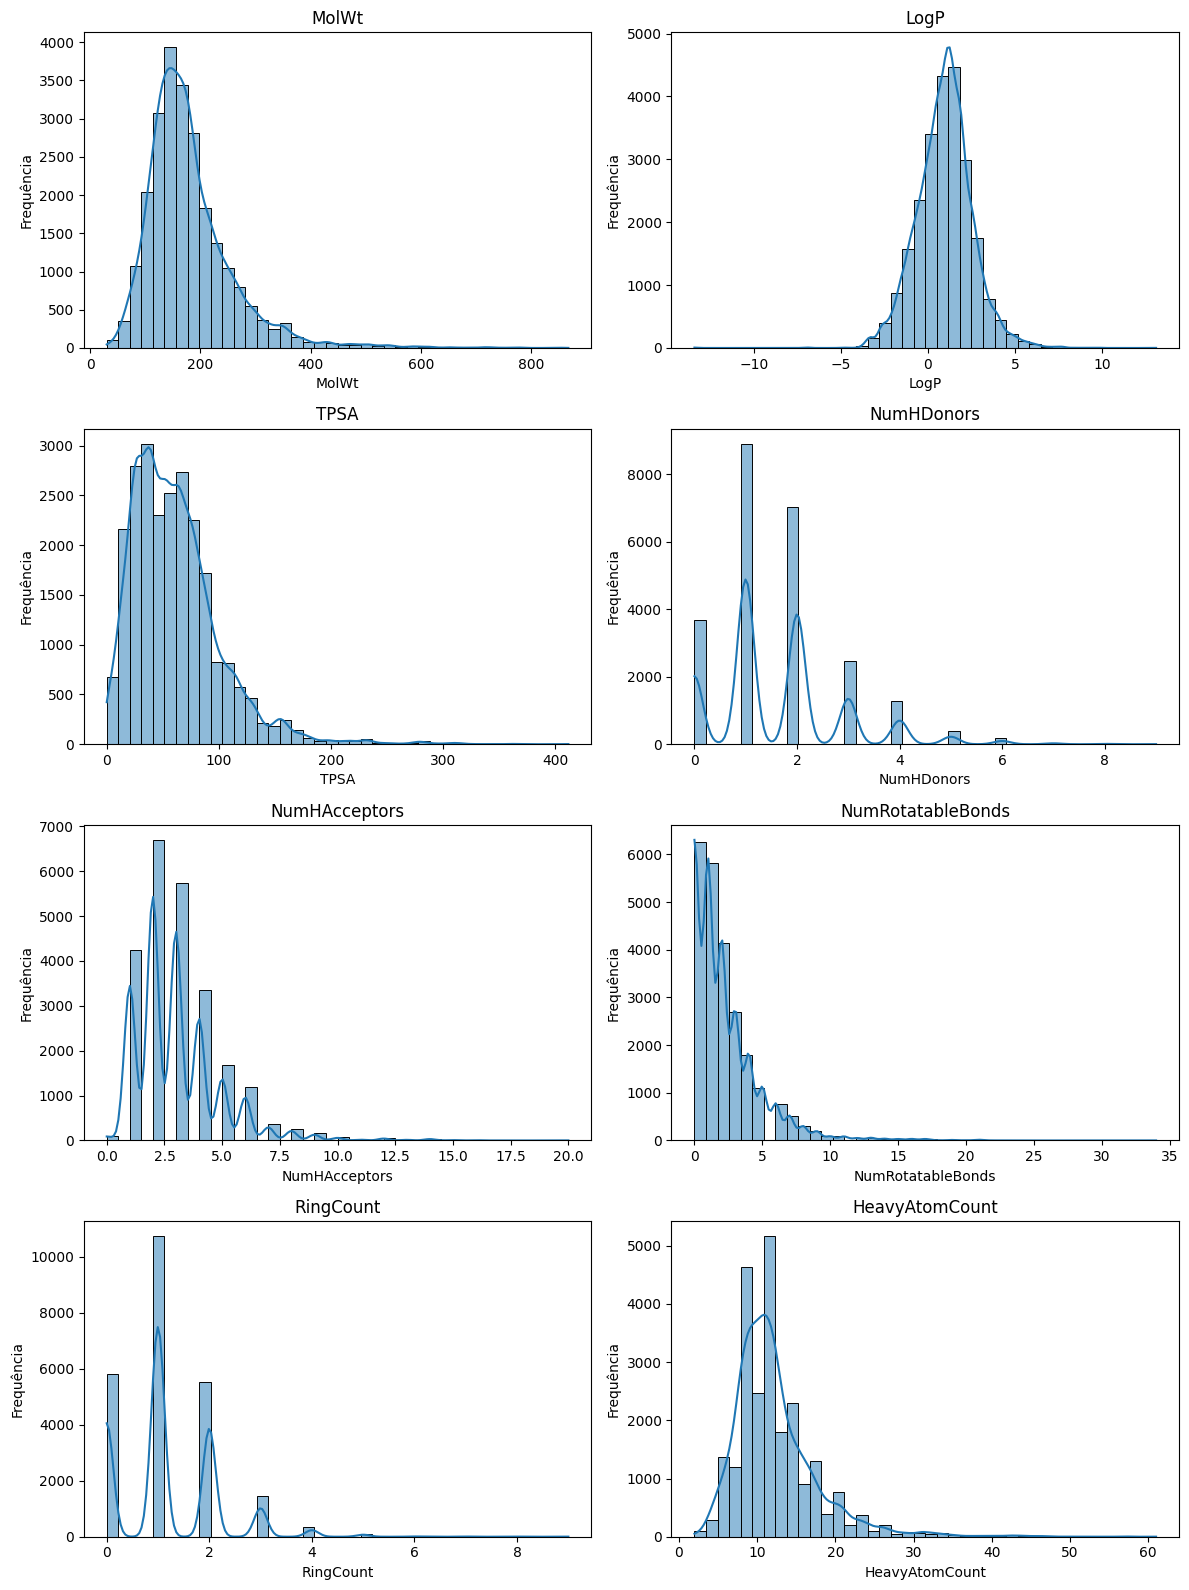

In [347]:
# Histogramas dos descritores (visão global)

features = X_iupac_rdkit.columns.tolist()

n_feats = len(features)
n_cols = 2
n_rows = int(np.ceil(n_feats / n_cols))

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(12, 4 * n_rows),
    sharex=False,
    sharey=False
)

axes = axes.flatten()

for i, feat in enumerate(features):
    sns.histplot(
        X_iupac_rdkit[feat],
        bins=40,
        kde=True,
        ax=axes[i]
    )
    axes[i].set_title(feat)
    axes[i].set_xlabel(feat)
    axes[i].set_ylabel("Frequência")

# Remove eixos vazios (caso sobre algum)
for j in range(n_feats, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [357]:
# Gráfico de barras: média ± desvio-padrão

summary_stats2_iupac_rdkit = (
    pd.concat([X_iupac_rdkit, y_iupac], axis=1)
      .groupby("pKa_class")
      .agg(["mean", "std"])
)

summary_stats2_iupac_rdkit

MolWt                  LogP                 TPSA             \
                 mean         std      mean       std       mean        std   
pKa_class                                                                     
0          181.656805   75.346175  1.067189  1.524048  61.957035  39.264419   
1          177.460943   82.152712  0.771021  1.660219  58.837388  39.263992   
2          188.390462  102.276876  1.022763  1.713506  68.515103  48.423424   

          NumHDonors           NumHAcceptors           NumRotatableBonds  \
                mean       std          mean       std              mean   
pKa_class                                                                  
0           1.467960  1.217070      3.011433  1.866687          2.050318   
1           1.829268  1.196054      2.977377  1.737745          2.531401   
2           2.016176  1.315455      3.333824  2.278356          1.894118   

                    RingCount           HeavyAtomCount            
                std      mean       std           mean       std  
pKa_class                                                         
0          2.467562  1.228864  0.934468      12.317572  5.077902  
1          2.722264  1.067633  1.001835      12.075527  5.600164  
2          2.214201  1.340441  1.009657      12.930882  6.772749

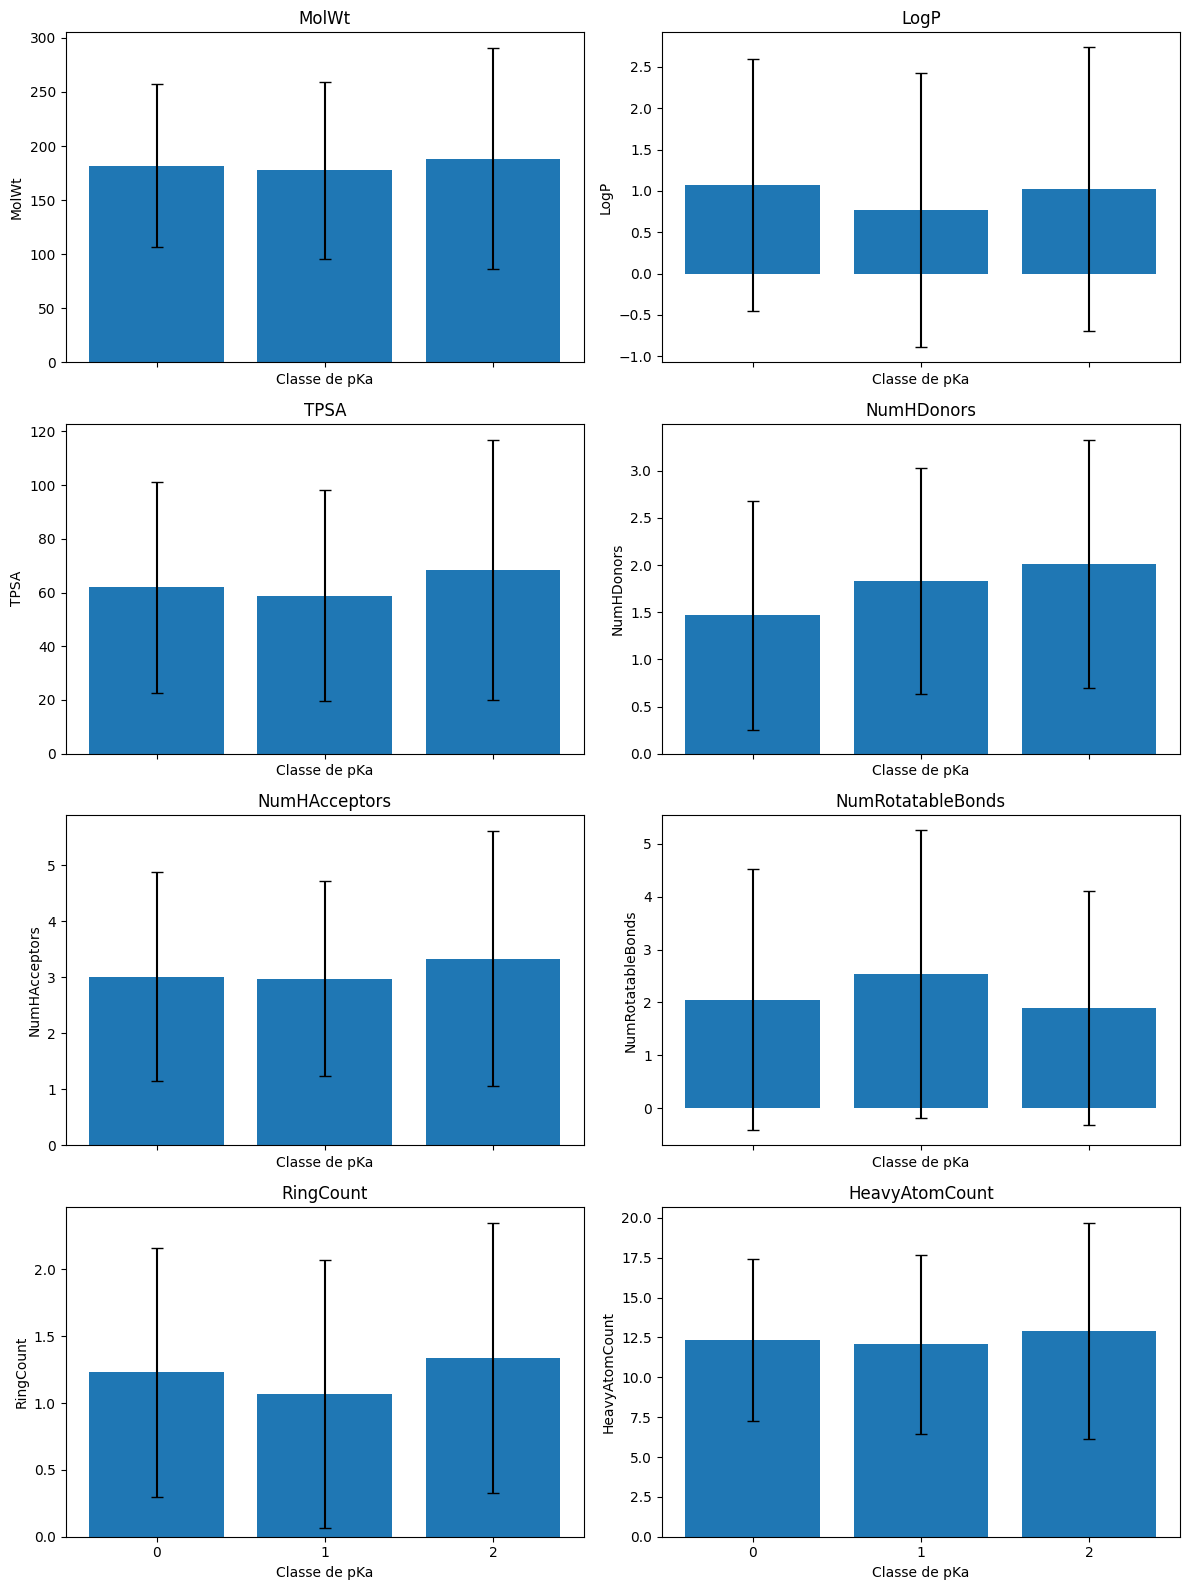

In [358]:
features = X_iupac_rdkit.columns.tolist()
classes = summary_stats2_iupac_rdkit.index.astype(str)

n_feats = len(features)
n_cols = 2
n_rows = int(np.ceil(n_feats / n_cols))

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(12, 4 * n_rows),
    sharex=True
)

axes = axes.flatten()

for i, feat in enumerate(features):
    means = summary_stats2_iupac_rdkit[(feat, "mean")]
    stds  = summary_stats2_iupac_rdkit[(feat, "std")]

    axes[i].bar(
        classes,
        means.values,
        yerr=stds.values,
        capsize=4
    )

    axes[i].set_title(feat)
    axes[i].set_xlabel("Classe de pKa")
    axes[i].set_ylabel(feat)

# Remove eixos vazios
for j in range(n_feats, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [300]:
# Análise Descritiva SAMPL6

summary_sampl6_rdkit = X_sampl6_rdkit.describe().T
summary_sampl6_rdkit

,count,mean,std,min,25%,50%,75%,max
MolWt,1765.0,269.288134,147.364825,31.0580,153.137,242.3010,364.4490,1203.4990
LogP,1765.0,1.634084,1.697630,-8.3677,0.541,1.5426,2.6949,11.6087
TPSA,1765.0,65.419314,47.711558,0.0000,32.260,55.2300,87.6200,490.6600
NumHDonors,1765.0,1.729745,1.560585,0.0000,1.000,1.0000,2.0000,18.0000
NumHAcceptors,1765.0,3.769972,2.723731,0.0000,2.000,3.0000,5.0000,18.0000
NumRotatableBonds,1765.0,3.333711,2.856195,0.0000,1.000,3.0000,5.0000,39.0000
RingCount,1765.0,2.263456,1.740294,0.0000,1.000,2.0000,3.0000,10.0000
HeavyAtomCount,1765.0,18.708215,10.276637,2.0000,11.000,17.0000,25.0000,85.0000


In [303]:
# Ajustar os nomes 

summary_sampl6_rdkit = summary_sampl6_rdkit.rename(columns={
    "count": "n",
    "mean": "mean",
    "std": "std",
    "min": "min",
    "25%": "Q1",
    "50%": "median",
    "75%": "Q3",
    "max": "max"
})

In [306]:
# Exportar diretamente para LaTeX

latex_sampl6_rdkit = summary_sampl6_rdkit.to_latex(
    float_format="%.3f",
    caption="Estatísticas descritivas dos descritores RDKit selecionados para o conjunto de dados SAMPL6.",
    label="tab:descritivas_iupac"
)

print(latex_sampl6_rdkit)

\begin{table}
\caption{Estatísticas descritivas dos descritores RDKit selecionados para o conjunto de dados SAMPL6.}
\label{tab:descritivas_iupac}
\begin{tabular}{lrrrrrrrr}
\toprule
 & n & mean & std & min & Q1 & median & Q3 & max \\
\midrule
MolWt & 1765.000 & 269.288 & 147.365 & 31.058 & 153.137 & 242.301 & 364.449 & 1203.499 \\
LogP & 1765.000 & 1.634 & 1.698 & -8.368 & 0.541 & 1.543 & 2.695 & 11.609 \\
TPSA & 1765.000 & 65.419 & 47.712 & 0.000 & 32.260 & 55.230 & 87.620 & 490.660 \\
NumHDonors & 1765.000 & 1.730 & 1.561 & 0.000 & 1.000 & 1.000 & 2.000 & 18.000 \\
NumHAcceptors & 1765.000 & 3.770 & 2.724 & 0.000 & 2.000 & 3.000 & 5.000 & 18.000 \\
NumRotatableBonds & 1765.000 & 3.334 & 2.856 & 0.000 & 1.000 & 3.000 & 5.000 & 39.000 \\
RingCount & 1765.000 & 2.263 & 1.740 & 0.000 & 1.000 & 2.000 & 3.000 & 10.000 \\
HeavyAtomCount & 1765.000 & 18.708 & 10.277 & 2.000 & 11.000 & 17.000 & 25.000 & 85.000 \\
\bottomrule
\end{tabular}
\end{table}



In [335]:
y_sampl6_cont = sampl6_rdkit['pKa'] # Variável alvo contínua para regressão (válido para RDKit e Mordred)

pka_sampl6_summary = y_sampl6_cont.describe()
pka_sampl6_summary

count    1765.000000
mean       41.940468
std       486.930518
min        -4.900000
25%         4.215000
50%         7.400000
75%         9.200000
max      9555.000000
Name: pKa, dtype: float64

In [336]:
pka_sampl6_summary = pka_sampl6_summary.rename(index={
    "count": "n",
    "mean": "mean",
    "std": "std",
    "min": "min",
    "25%": "Q1",
    "50%": "median",
    "75%": "Q3",
    "max": "max"
})

In [338]:
pka_sampl6_latex = pka_sampl6_summary.to_frame(name="pKa").to_latex(
    float_format="%.3f",
    caption="Estatísticas descritivas dos valores contínuos de $\\mathrm{p}K_a$ no conjunto SAMPL6.",
    label="tab:estatistica_pka_cont_sampl6"
)

print(pka_sampl6_latex)

\begin{table}
\caption{Estatísticas descritivas dos valores contínuos de $\mathrm{p}K_a$ no conjunto SAMPL6.}
\label{tab:estatistica_pka_cont_sampl6}
\begin{tabular}{lr}
\toprule
 & pKa \\
\midrule
n & 1765.000 \\
mean & 41.940 \\
std & 486.931 \\
min & -4.900 \\
Q1 & 4.215 \\
median & 7.400 \\
Q3 & 9.200 \\
max & 9555.000 \\
\bottomrule
\end{tabular}
\end{table}



In [340]:
data_sampl6_rdkit = pd.concat([X_sampl6_rdkit, y_sampl6], axis=1)

In [341]:
# Média por classe SAMPL6

summary_by_class_sampl6_rdkit = (
    data_sampl6_rdkit
    .groupby("pKa_class")
    .describe()
    .T
)

summary_by_class_sampl6_rdkit

pKa_class                      0           1           2
MolWt          count  817.000000  855.000000   93.000000
               mean   293.580406  257.431425  164.887054
               std    153.968258  139.379307   90.718420
               min     46.025000   31.058000   32.042000
               25%    162.188000  153.159000   85.150000
...                          ...         ...         ...
HeavyAtomCount min      3.000000    2.000000    2.000000
               25%     11.000000   11.000000    6.000000
               50%     19.000000   16.000000   11.000000
               75%     29.000000   23.000000   15.000000
               max     65.000000   85.000000   30.000000

[64 rows x 3 columns]

In [342]:
summary_by_class_sampl6_rdkit = summary_by_class_sampl6_rdkit.rename(index={
    "count": "n",
    "mean": "mean",
    "std": "std",
    "min": "min",
    "25%": "Q1",
    "50%": "median",
    "75%": "Q3",
    "max": "max"
})

summary_by_class_sampl6_rdkit

pKa_class                       0           1           2
MolWt          n       817.000000  855.000000   93.000000
               mean    293.580406  257.431425  164.887054
               std     153.968258  139.379307   90.718420
               min      46.025000   31.058000   32.042000
               Q1      162.188000  153.159000   85.150000
...                           ...         ...         ...
HeavyAtomCount min       3.000000    2.000000    2.000000
               Q1       11.000000   11.000000    6.000000
               median   19.000000   16.000000   11.000000
               Q3       29.000000   23.000000   15.000000
               max      65.000000   85.000000   30.000000

[64 rows x 3 columns]

In [343]:
latex_by_class_sampl6_rdkit = summary_by_class_sampl6_rdkit.to_latex(
    longtable=True,
    float_format="%.3f",
    caption="Estatísticas descritivas dos descritores RDKit selecionados para o conjunto de dados SAMPL6, estratificadas pelas classes discretas de $\\mathrm{p}K_a$.",
    label="tab:estatistica_pka_disc_sampl6"
)

print(latex_by_class_sampl6_rdkit)

\begin{longtable}{llrrr}
\caption{Estatísticas descritivas dos descritores RDKit selecionados para o conjunto de dados SAMPL6, estratificadas pelas classes discretas de $\mathrm{p}K_a$.} \label{tab:estatistica_pka_disc_sampl6} \\
\toprule
 & pKa_class & 0 & 1 & 2 \\
\midrule
\endfirsthead
\caption[]{Estatísticas descritivas dos descritores RDKit selecionados para o conjunto de dados SAMPL6, estratificadas pelas classes discretas de $\mathrm{p}K_a$.} \\
\toprule
 & pKa_class & 0 & 1 & 2 \\
\midrule
\endhead
\midrule
\multicolumn{5}{r}{Continued on next page} \\
\midrule
\endfoot
\bottomrule
\endlastfoot
\multirow[t]{8}{*}{MolWt} & n & 817.000 & 855.000 & 93.000 \\
 & mean & 293.580 & 257.431 & 164.887 \\
 & std & 153.968 & 139.379 & 90.718 \\
 & min & 46.025 & 31.058 & 32.042 \\
 & Q1 & 162.188 & 153.159 & 85.150 \\
 & median & 275.285 & 233.311 & 150.181 \\
 & Q3 & 418.516 & 324.426 & 211.261 \\
 & max & 1139.764 & 1203.499 & 406.461 \\
\cline{1-5}
\multirow[t]{8}{*}{LogP} & n & 817.00

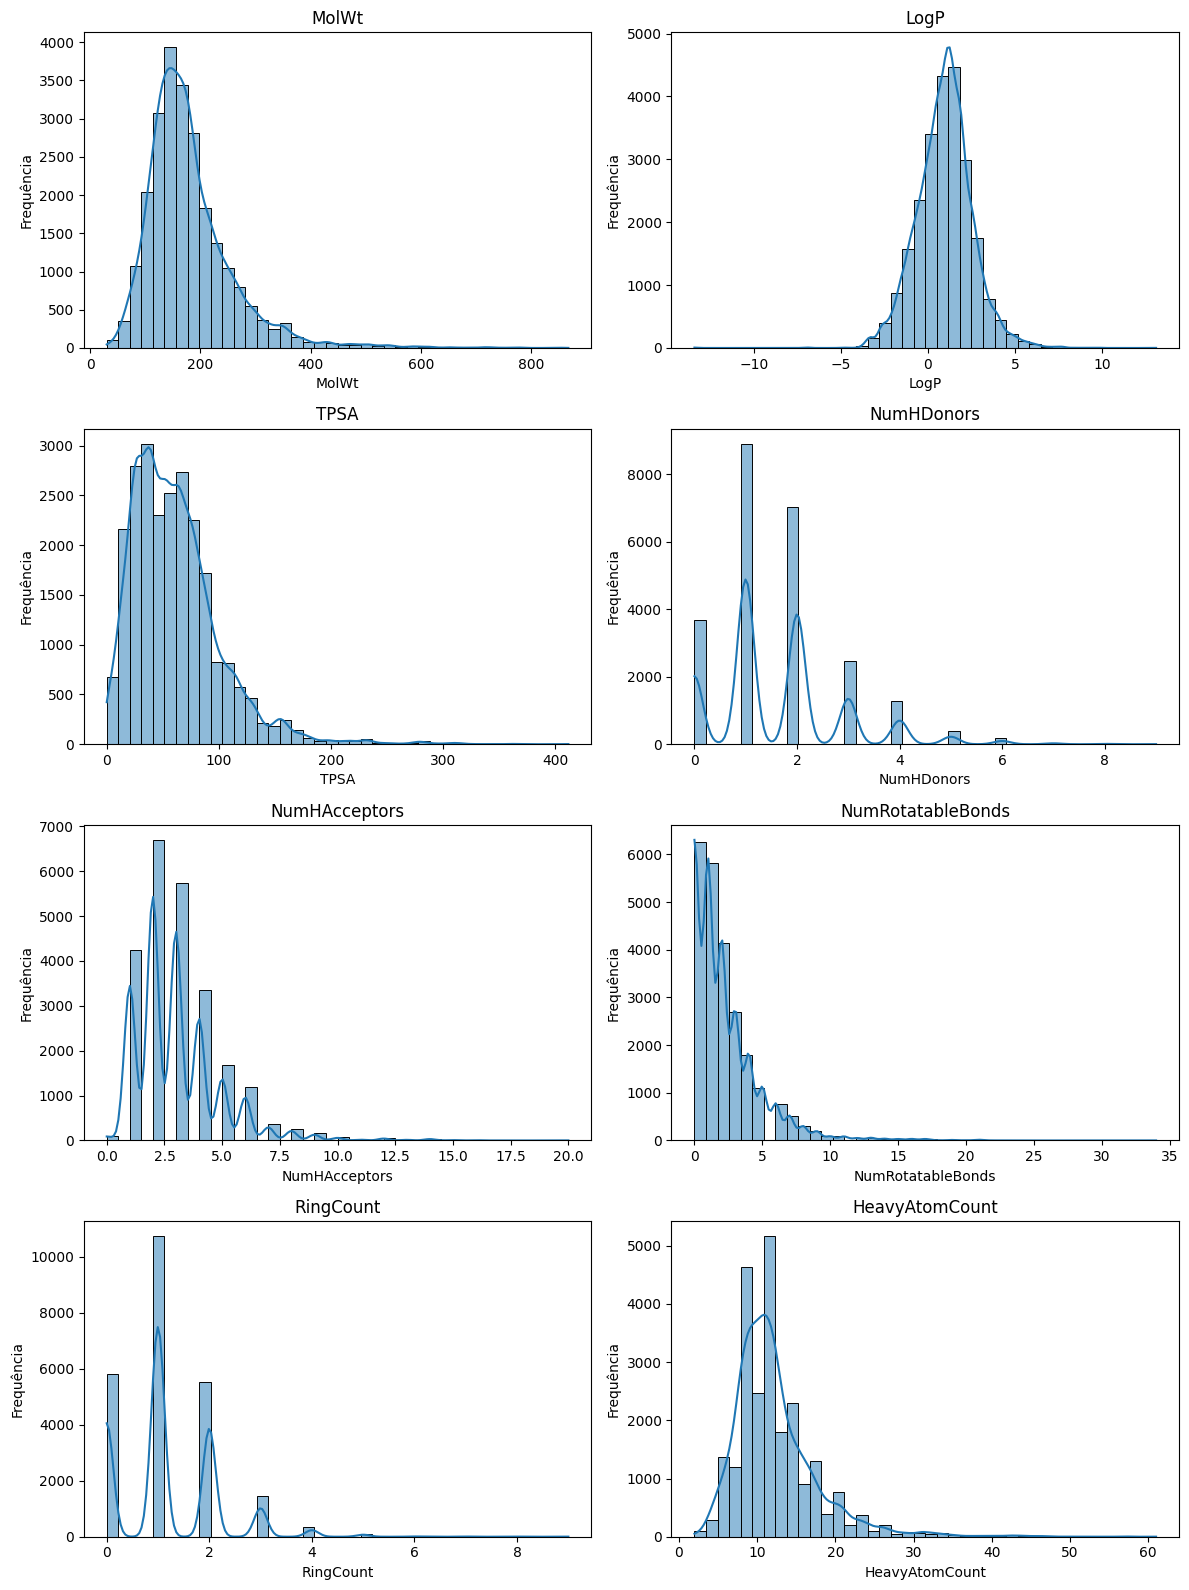

In [360]:
# Histogramas dos descritores (visão global)

features = X_sampl6_rdkit.columns.tolist()

n_feats = len(features)
n_cols = 2
n_rows = int(np.ceil(n_feats / n_cols))

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(12, 4 * n_rows),
    sharex=False,
    sharey=False
)

axes = axes.flatten()

for i, feat in enumerate(features):
    sns.histplot(
        X_iupac_rdkit[feat],
        bins=40,
        kde=True,
        ax=axes[i]
    )
    axes[i].set_title(feat)
    axes[i].set_xlabel(feat)
    axes[i].set_ylabel("Frequência")

# Remove eixos vazios (caso sobre algum)
for j in range(n_feats, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [361]:
# Gráfico de barras: média ± desvio-padrão

summary_stats2_sampl6_rdkit = (
    pd.concat([X_sampl6_rdkit, y_sampl6], axis=1)
      .groupby("pKa_class")
      .agg(["mean", "std"])
)

summary_stats2_sampl6_rdkit

MolWt                  LogP                 TPSA             \
                 mean         std      mean       std       mean        std   
pKa_class                                                                     
0          293.580406  153.968258  1.761240  1.640808  72.892754  46.520101   
1          257.431425  139.379307  1.589465  1.768457  59.930480  48.807785   
2          164.887054   90.718420  0.927231  1.296607  50.227419  36.472514   

          NumHDonors           NumHAcceptors           NumRotatableBonds  \
                mean       std          mean       std              mean   
pKa_class                                                                  
0           1.660955  1.439586      4.124847  2.875110          3.559364   
1           1.781287  1.696567      3.591813  2.586341          3.288889   
2           1.860215  1.229982      2.290323  1.791166          1.763441   

                    RingCount           HeavyAtomCount             
                std      mean       std           mean        std  
pKa_class                                                          
0          2.754535  2.511628  1.785748      20.248470  10.629602  
1          2.950339  2.141520  1.701314      18.026901   9.854467  
2          2.314406  1.204301  1.048385      11.440860   6.524973

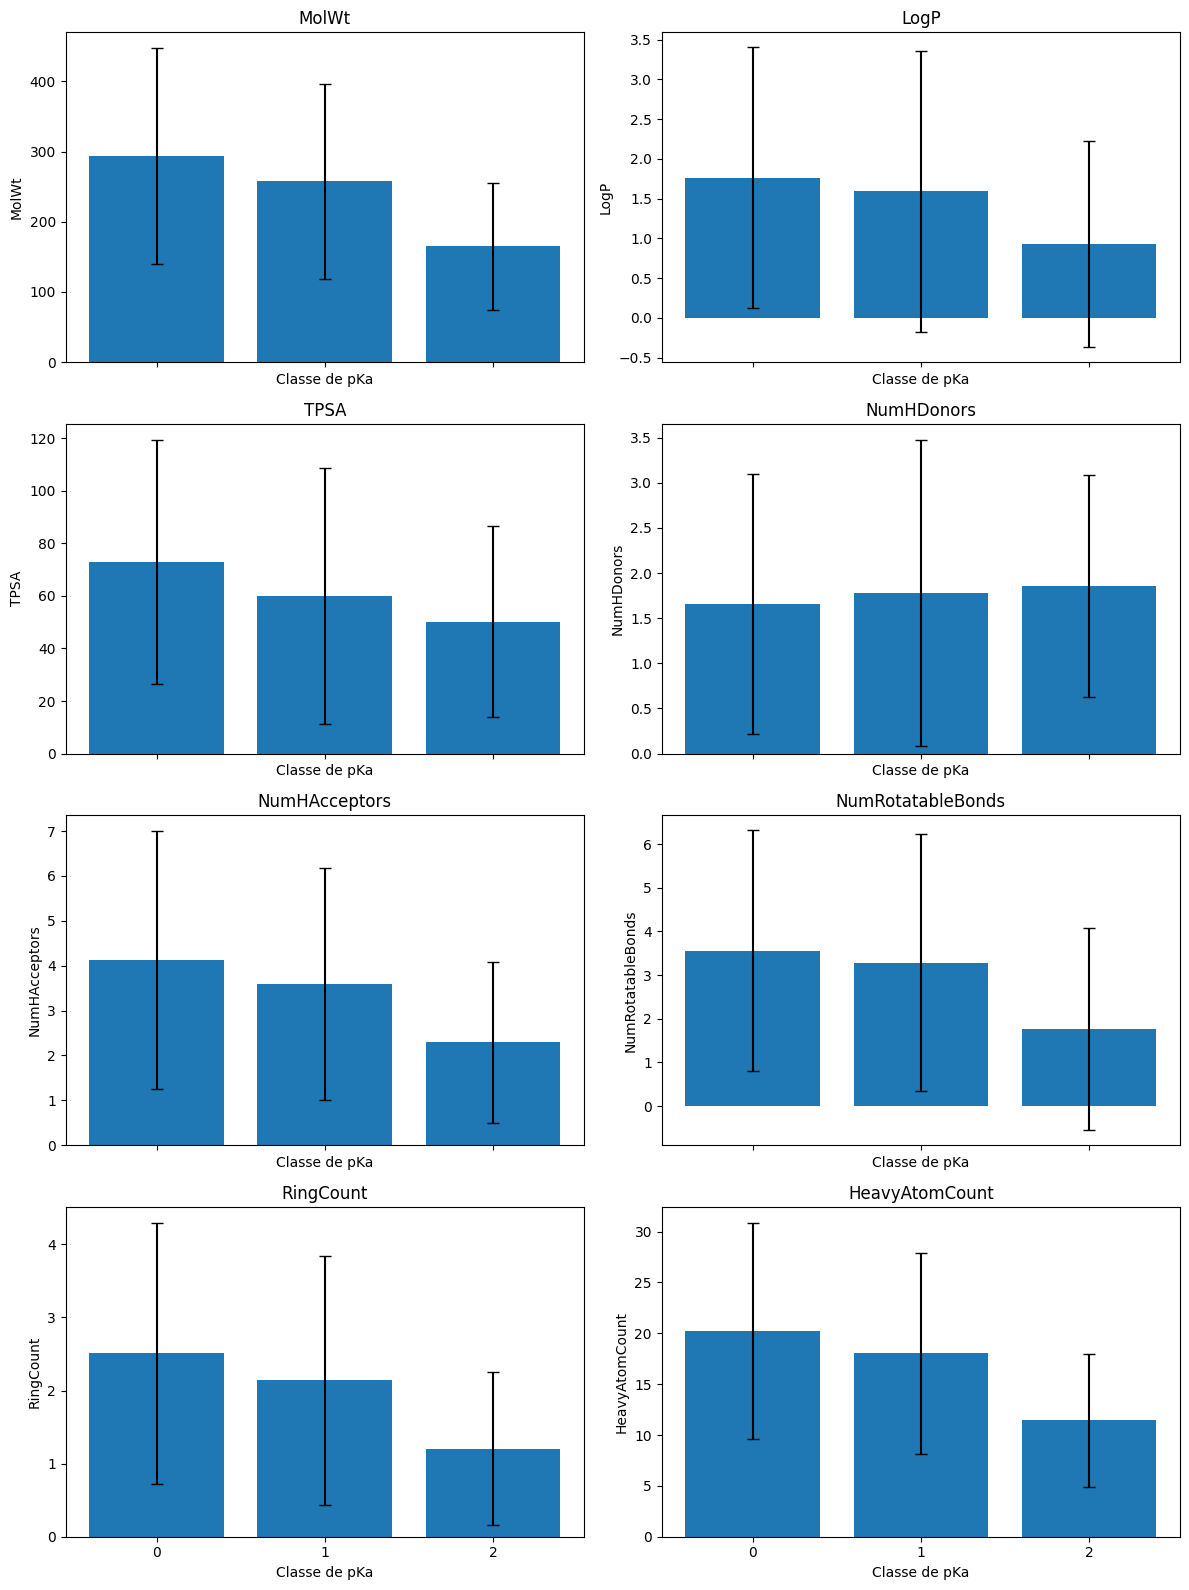

In [362]:
features = X_sampl6_rdkit.columns.tolist()
classes = summary_stats2_sampl6_rdkit.index.astype(str)

n_feats = len(features)
n_cols = 2
n_rows = int(np.ceil(n_feats / n_cols))

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(12, 4 * n_rows),
    sharex=True
)

axes = axes.flatten()

for i, feat in enumerate(features):
    means = summary_stats2_sampl6_rdkit[(feat, "mean")]
    stds  = summary_stats2_sampl6_rdkit[(feat, "std")]

    axes[i].bar(
        classes,
        means.values,
        yerr=stds.values,
        capsize=4
    )

    axes[i].set_title(feat)
    axes[i].set_xlabel("Classe de pKa")
    axes[i].set_ylabel(feat)

# Remove eixos vazios
for j in range(n_feats, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [55]:
print(X_sampl6_rdkit.shape)

(1765, 8)


In [56]:
print(X_iupac_mordred.shape)

(24017, 1186)


In [57]:
print(X_sampl6_mordred.shape)

(1765, 1186)


#### Os descritores moleculares foram calculados a partir das representações SMILES utilizando as bibliotecas RDKit e Mordred. O RDKit foi empregado para a extração de descritores físico-químicos clássicos, como massa molecular, logP, área de superfície polar topológica (TPSA), número de doadores e aceitadores de ligações de hidrogênio e propriedades estruturais básicas. Complementarmente, o pacote Mordred foi utilizado para gerar um conjunto mais amplo de descritores moleculares, abrangendo características topológicas, eletrônicas e geométricas. Apenas descritores numéricos válidos foram mantidos para a etapa de modelagem, enquanto informações de identidade química foram preservadas separadamente como metadados.

## Discretização da Variável-Alvo

#### Os valores contínuos de pKa foram discretizados em três faixas ordinais — baixo (pKa < 7), médio (7 ≤ pKa ≤ 11) e alto (pKa > 11) — e codificados numericamente por meio de um esquema de label encoding. Essa abordagem preserva a relação ordinal entre as classes e evita o aumento artificial da dimensionalidade associado ao one-hot encoding, favorecendo a estabilidade e a interpretabilidade dos modelos de aprendizado de máquina.

In [58]:
# Dicionário conceitual

pka_classes = {
    "baixo": 0,
    "medio": 1,
    "alto": 2
}

In [59]:
# Função para discretização dos valores contínuos de pKa

def pka_to_class(pka):
    if pka < 7:
        return 0      # baixo
    elif pka <= 11:
        return 1      # médio
    else:
        return 2      # alto

In [60]:
# Aplicar a função para discretização dos valores contínuos de pKa com lambda e garantir valores decimais

# Datasets IUPAC

iupac_rdkit['pKa_class'] = iupac_df['pka_value'].astype(float).apply(
    lambda x: pka_to_class(x)
)

iupac_mordred['pKa_class'] = iupac_df['pka_value'].astype(float).apply(
    lambda x: pka_to_class(x)
)

# Datasets SAMPL6

sampl6_rdkit['pKa_class'] = sampl6_df['pKa'].astype(float).apply(
    lambda x: pka_to_class(x)
)

sampl6_mordred['pKa_class'] = sampl6_df['pKa'].astype(float).apply(
    lambda x: pka_to_class(x)
)

In [61]:
# Contagem de valores discretos de 'pKa_class' para o dataset IUPAC

iupac_rdkit['pKa_class'].value_counts().sort_index()

pKa_class
0    14170
1     8487
2     1360
Name: count, dtype: int64

In [108]:
print(iupac_rdkit['pKa_class'].shape)

(24017,)


In [62]:
# Contagem de valores discretos de 'pKa_class' para o dataset SAMPL6

sampl6_rdkit['pKa_class'].value_counts().sort_index()

pKa_class
0    817
1    855
2     93
Name: count, dtype: int64

In [109]:
print(sampl6_rdkit['pKa_class'].shape)

(1765,)


#### Em ambos os datasets, as classes da variável 'pka_class' estão desbalanceadas, ou seja, a quantidade de valores para cada uma das 3 discretizações é desproporcional. Portanto, será necessário balancear as classes especialmente porque o trabalho faz uso de classificação multiclasse e a classe 2 (pKa alto) é quimicamente relevante para conversão de CO2. Se ficarem desbalanceadas, as métricas como acurácia podem ficar enganosas e modelos podem ignorar completamente a classe minoritária, criando-se um viés no modelo.

#### Contudo, o balanceamento só será realizado depois da divisão em treino-teste e da padronização dos dados, pois o balanceamento só é aplicado nos dados de treino. Os conjuntos de dados apresentaram desbalanceamento entre as classes discretizadas de pKa, especialmente para a classe correspondente a valores elevados de pKa. Para mitigar esse efeito sem introduzir instâncias artificiais potencialmente inconsistentes do ponto de vista químico, será adotada a ponderação das classes (class weighting) durante o treinamento dos modelos supervisionados. O balanceamento será aplicado exclusivamente aos conjuntos de treinamento, após a padronização das variáveis, evitando vazamento de informação para os dados de teste.

#### Agora foi necessário fazer a separação conceitual essencial (química + ML). Em problemas de química computacional + aprendizado de máquina, os dados devem ser organizados em duas camadas: a Camada de IDENTIDADE QUÍMICA (metadados), que não entram no modelo, mas identificam o composto ('SMILES', 'InChI', 'acidity_label', 'ID', 'Molecule'), e a Camada de REPRESENTAÇÃO NUMÉRICA (features), que entram no modelo para classificação/regressão (descritores RDKit e Mordred).

#### Portanto, as informações estruturais dos compostos químicos, tais como 'SMILES', 'InChI', 'acidity_label', 'ID' e 'Molecule', foram preservadas como metadados para fins de rastreabilidade e interpretação química dos resultados, mas não foram utilizadas diretamente como variáveis preditoras nos modelos de aprendizado de máquina. A modelagem foi conduzida exclusivamente a partir de descritores físico-químicos numéricos, extraídos a partir dessas representações estruturais, garantindo que os modelos operassem apenas sobre variáveis quantitativas adequadas ao processo de treinamento.

## Organização de todos os Datasets (Preditoras + Alvo + Metadados)

In [214]:
# IUPAC

y_iupac = iupac_rdkit['pKa_class'] # Variável alvo discretizada para classificação (válido para RDKit e Mordred)
y_iupac_cont = iupac_rdkit['pka_value'] # Variável alvo contínua para regressão (válido para RDKit e Mordred)
iupac_meta = iupac_df[['SMILES', 'InChI', 'acidity_label']] # Metadados (identidade química)

# SAMPL6

y_sampl6 = sampl6_rdkit['pKa_class'] # Variável alvo discretizada para classificação (válido para RDKit e Mordred)
y_sampl6_cont = sampl6_rdkit['pKa'] # Variável alvo contínua para regressão (válido para RDKit e Mordred)
sampl6_meta = sampl6_df[['SMILES', 'ID', 'Molecule']] # Metadados (identidade química)

In [112]:
print(y_iupac.shape)

(24017,)


In [113]:
print(y_sampl6.shape)

(1765,)


In [64]:
datasets = {
    "iupac": {
        "meta": iupac_meta,
        "y": y_iupac,
        "rdkit": X_iupac_rdkit,
        "mordred": X_iupac_mordred
    },
    "sampl6": {
        "meta": sampl6_meta,
        "y": y_sampl6,
        "rdkit": X_sampl6_rdkit,
        "mordred": X_sampl6_mordred
    }
}

#### Os descritores moleculares foram analisados separadamente conforme sua origem. Os descritores clássicos da biblioteca RDKit foram empregados para análises estatísticas e interpretação química, enquanto os descritores de alta dimensionalidade gerados pela biblioteca Mordred foram utilizados em etapas de seleção de atributos e modelagem preditiva, evitando a concatenação direta entre ambos os conjuntos.

## Resolver Pequenas Porcentagem de NaN Restantes no Mordred

#### Os valores ausentes remanescentes foram tratados por exclusão de registros (IUPAC) ou imputação pela mediana (SAMPL6), antes das análises estatísticas e de aprendizado de máquina.

#### Remover linhas com NaN para o dataset IUPAC: Dataset grande, poucos NaN por coluna e não introduz viés

In [65]:
X_iupac_mordred = X_iupac_mordred.dropna()

y_iupac = y_iupac.loc[X_iupac_mordred.index] # Alinhar o alvo

#### Imputar os NaN para o dataset SAMPL6 usando a mediana: Dataset pequeno e remover linhas pode ser um problema

In [66]:
imputer = SimpleImputer(strategy="median")

X_sampl6_mordred = pd.DataFrame(
    imputer.fit_transform(X_sampl6_mordred),
    columns=X_sampl6_mordred.columns,
    index=X_sampl6_mordred.index
)

# Nenhuma linha foi removida, o índice foi preservado. Portanto, não precisa alinhar o y_sampl6.

In [67]:
# Verificar se ainda há valores NaN

X_iupac_mordred.isna().sum().sum()

0

In [68]:
X_sampl6_mordred.isna().sum().sum()

0

In [69]:
print(X_iupac_mordred.shape)

(22103, 1186)


In [70]:
print(X_sampl6_mordred.shape)

(1765, 1186)


In [71]:
# Verificar indexação

X_iupac_mordred.index.equals(y_iupac.index)

True

In [72]:
X_sampl6_mordred.index.equals(y_sampl6.index)

True

## Análise de Correlação

### 1) Datasets RDKit

#### Correlação estatística (Pearson/Spearman) com variável $\mathrm{p}K_a$ contínua:

In [83]:
# Juntar descritores + pKa contínuo para Correlação de Pearson

# IUPAC

iupac_corr_df = X_iupac_rdkit.copy()

iupac_corr_df["pKa"] = iupac_df["pka_value"].astype(float)

# SAMPL6

sampl6_corr_df = X_sampl6_rdkit.copy()

sampl6_corr_df["pKa"] = sampl6_df["pKa"].astype(float)

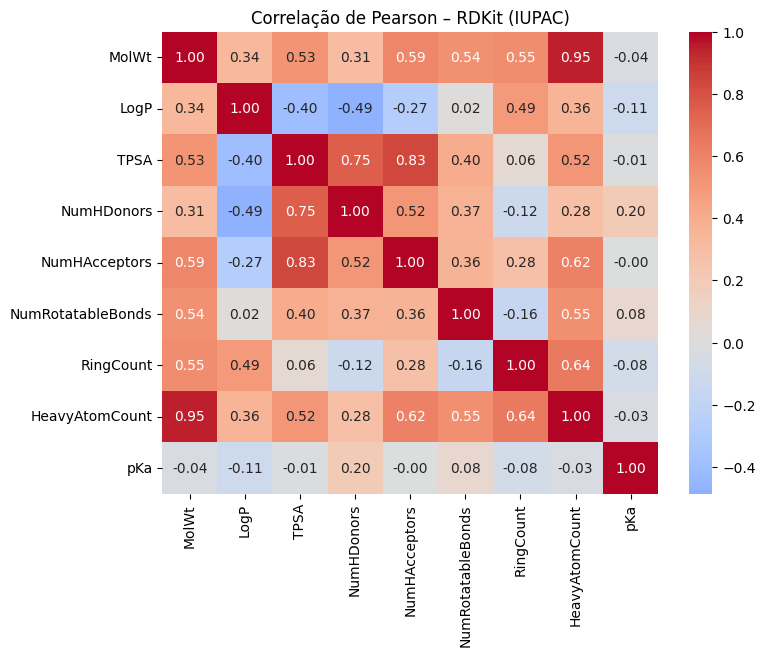

In [77]:
# Heatmap – IUPAC

plt.figure(figsize=(8, 6))
sns.heatmap(
    iupac_corr_df.corr(),
    cmap="coolwarm",
    center=0,
    annot=True,
    fmt=".2f"
)
plt.title("Correlação de Pearson – RDKit (IUPAC)")
plt.show()

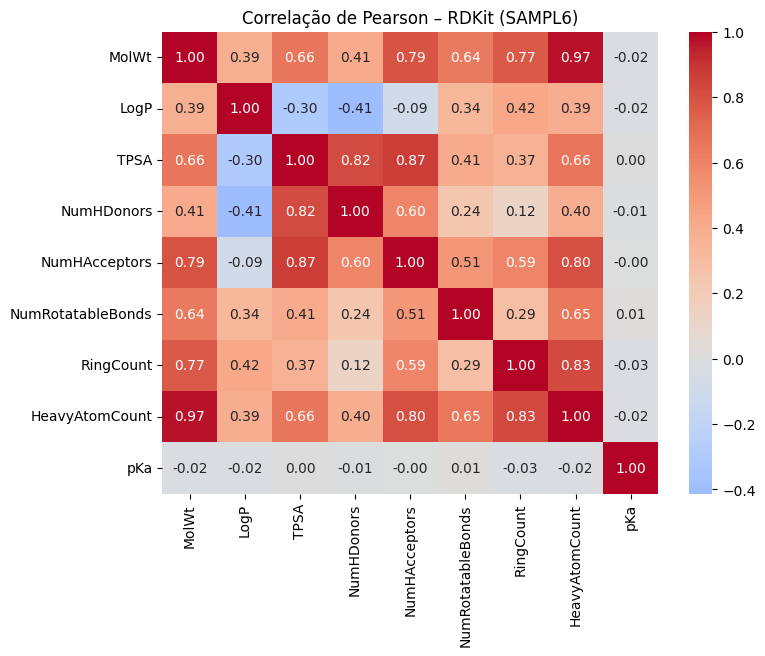

In [78]:
# Heatmap - SAMPL6

plt.figure(figsize=(8, 6))
sns.heatmap(
    sampl6_corr_df.corr(),
    cmap="coolwarm",
    center=0,
    annot=True,
    fmt=".2f"
)
plt.title("Correlação de Pearson – RDKit (SAMPL6)")
plt.show()

In [79]:
# Seleção de preditoras após a análise de Pearson para ambos os datasets 

selected_rdkit_features = [
    "LogP",
    "TPSA",
    "NumHDonors",
    "NumRotatableBonds",
    "RingCount"
]

X_iupac_rdkit_sel = X_iupac_rdkit[selected_rdkit_features] # dataset IUPAC

X_sampl6_rdkit_sel = X_sampl6_rdkit[selected_rdkit_features] # dataset SMAPL6

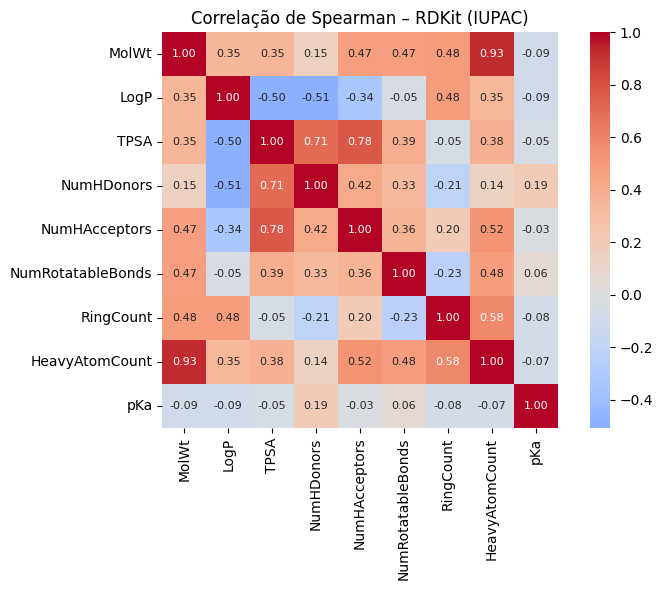

In [275]:
# Heatmap de Spearman

# IUPAC

spearman_matrix_iupac = iupac_corr_df.corr(method="spearman")

plt.figure(figsize=(8, 6))
sns.heatmap(
    spearman_matrix_iupac,
    cmap="coolwarm",
    center=0,
    square=True,
    annot=True,          # Mostra os valores
    fmt=".2f",           # Duas casas decimais
    annot_kws={"size": 8}
)
plt.title("Correlação de Spearman – RDKit (IUPAC)")
plt.tight_layout()
plt.show()

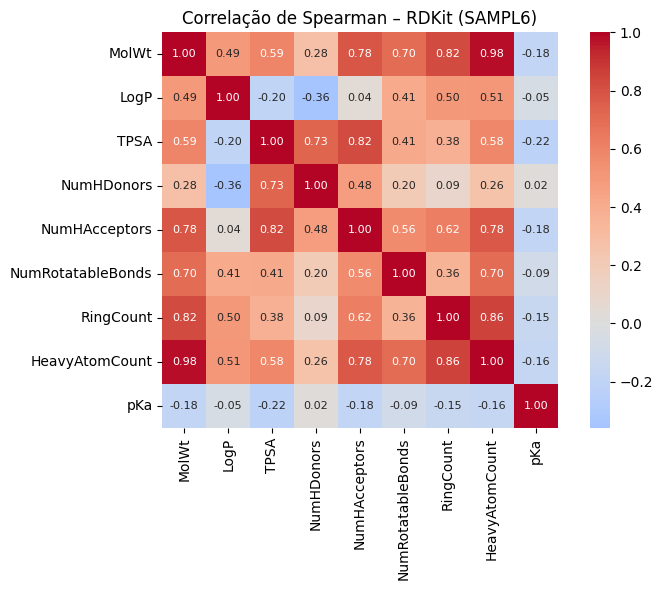

In [274]:
# SAMPL6

spearman_matrix_sampl6 = sampl6_corr_df.corr(method="spearman")

plt.figure(figsize=(8, 6))
sns.heatmap(
    spearman_matrix_sampl6,
    cmap="coolwarm",
    center=0,
    square=True,
    annot=True,          # Mostra os valores
    fmt=".2f",           # Duas casas decimais
    annot_kws={"size": 8}
)
plt.title("Correlação de Spearman – RDKit (SAMPL6)")
plt.tight_layout()
plt.show()

#### Inicialmente, foi realizada uma análise de correlação estatística entre os descritores físico-químicos clássicos gerados pela biblioteca RDKit e os valores contínuos de $\mathrm{p}K_a$. Para isso, utilizou-se o coeficiente de correlação de Pearson, adequado para variáveis contínuas, sendo a correlação de Spearman (ρ) empregada como análise complementar para avaliar possíveis relações monotônicas não lineares.

#### Observou-se que os coeficientes de correlação linear entre os descritores físico-químicos individuais e os valores de $\mathrm{p}K_a$ foram baixos, indicando a ausência de relações lineares diretas em ambos os datasets. Esse resultado era esperado, dado o caráter multifatorial e não linear do equilíbrio ácido–base, o qual depende de interações eletrônicas locais, efeitos de solvatação e da combinação de múltiplas propriedades moleculares. Tal comportamento reforça a necessidade do emprego de modelos de aprendizado de máquina capazes de capturar relações multivariadas e não lineares.

#### A análise de correlação de Pearson revelou forte multicolinearidade entre alguns descritores físico-químicos do RDKit, especialmente entre massa molecular, número de átomos pesados e contagem de anéis, bem como entre área de superfície polar topológica (TPSA) e o número de aceitadores de hidrogênio. Com base nesses resultados, descritores altamente redundantes (|r| > 0.8) foram removidos, resultando em um conjunto reduzido e menos colinear de preditores. Observou-se ainda que os descritores individuais apresentaram baixa correlação linear com o valor de $\mathrm{p}K_a$, indicando uma relação predominantemente não linear entre estrutura molecular e acidez/basicidade, o que justifica o uso de modelos de aprendizado de máquina mais complexos.

#### Além da correlação linear de Pearson, foi aplicada a correlação de Spearman (ρ) para avaliar relações monotônicas entre os descritores físico-químicos e os valores de $\mathrm{p}K_a$. Essa abordagem é particularmente adequada para sistemas químicos, nos quais as relações entre propriedades moleculares e acidez não são estritamente lineares. Os resultados indicaram correlações individuais moderadas a fracas, sugerindo que a predição do $\mathrm{p}K_a$ depende de interações multivariadas entre descritores, o que justifica o uso de modelos de aprendizado de máquina não lineares, tais como Gradient Boosting, Random Forest e MLP.

#### Análise estatística (discriminativa): Correlação com boxplots, Kruskal–Wallis e testes-t com faixas de $\mathrm{p}K_a$ discretas

In [278]:
# Boxplots: análise visual discriminativa

# Função para criar os boxplots

def boxplots_creation(X, y):
    """
    X : DataFrame com preditoras numéricas
    y : Series ou array com classes discretas de pKa
    """

    # Converte classes para categóricas com rótulos inteiros
    y_cat = pd.Series(y).astype(int).astype("category")
    
    features = X.columns.tolist()   # nomes das colunas
    n_feats = len(features)

    n_cols = 2
    n_rows = int(np.ceil(n_feats / n_cols))

    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(12, 4 * n_rows),
        sharex=False
    )

    axes = axes.flatten()

    for i, feat in enumerate(features):
        sns.boxplot(
            x=y_cat,
            y=X[feat],
            ax=axes[i]
        )
        axes[i].set_title(feat)
        axes[i].set_xlabel("Classe de pKa")
        axes[i].set_ylabel(feat)

    # Remove eixos vazios
    for j in range(n_feats, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

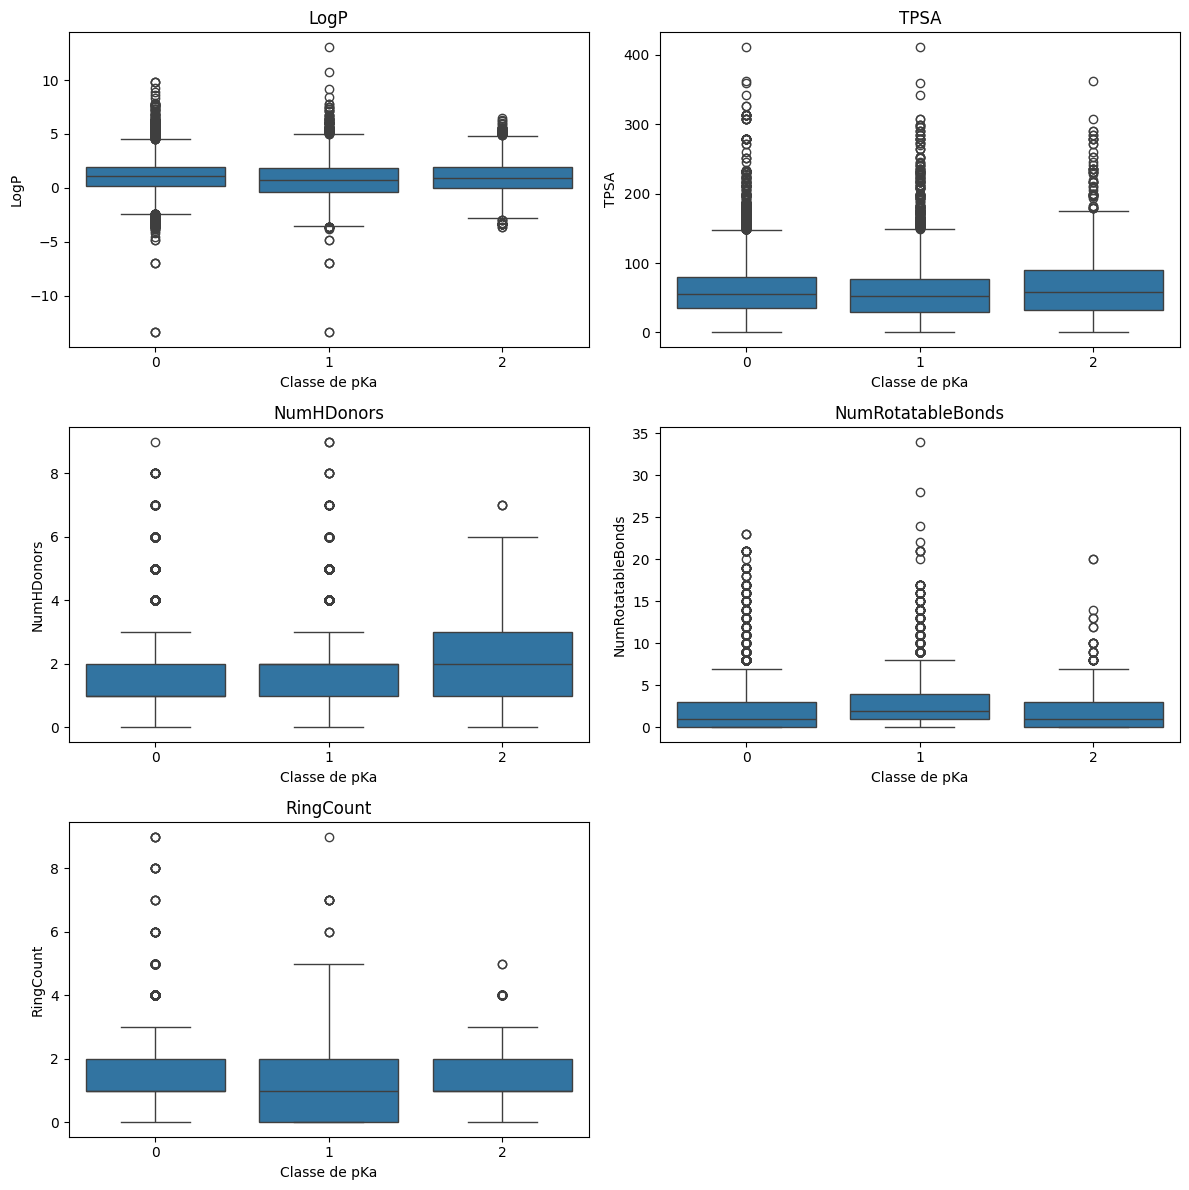

In [279]:
# IUPAC

boxplots_creation(X_iupac_rdkit_sel, y_iupac)

In [280]:
Q1 = X_iupac_rdkit_sel.quantile(0.25)
Q3 = X_iupac_rdkit_sel.quantile(0.75)
IQR = Q3 - Q1
outliers = (X_iupac_rdkit_sel < (Q1 - 1.5*IQR)) | (X_iupac_rdkit_sel > (Q3 + 1.5*IQR))
outliers.mean()

LogP                 0.022942
TPSA                 0.032394
NumHDonors           0.080360
NumRotatableBonds    0.039014
RingCount            0.019736
dtype: float64

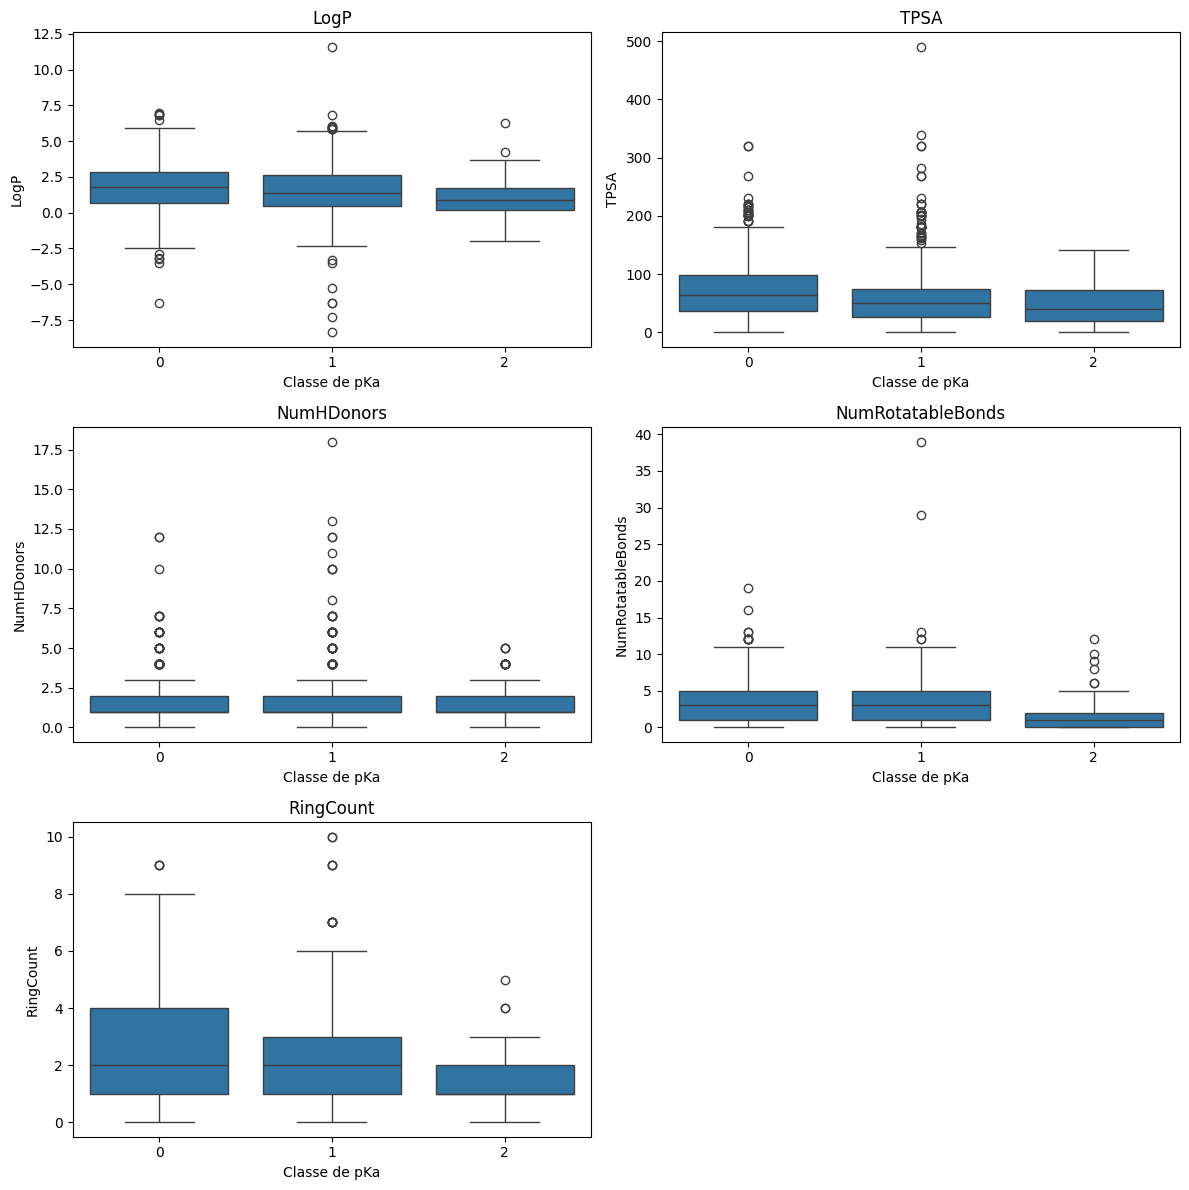

In [281]:
# SAMPL6

boxplots_creation(X_sampl6_rdkit_sel, y_sampl6)

In [89]:
Q1 = X_sampl6_rdkit_sel.quantile(0.25)
Q3 = X_sampl6_rdkit_sel.quantile(0.75)
IQR = Q3 - Q1
outliers = (X_sampl6_rdkit_sel < (Q1 - 1.5*IQR)) | (X_sampl6_rdkit_sel > (Q3 + 1.5*IQR))
outliers.mean()

LogP                 0.013598
TPSA                 0.041926
NumHDonors           0.094051
NumRotatableBonds    0.009065
RingCount            0.015297
dtype: float64

#### Boxplots foram utilizados para avaliar a capacidade discriminativa dos descritores físico-químicos em relação às três classes discretas de $\mathrm{p}K_a$. Essa análise permite identificar diferenças na distribuição das preditoras entre classes, fornecendo subsídios estatísticos para seleção de variáveis antes da modelagem preditiva.

#### A análise exploratória por meio de boxplots evidenciou que os descritores físico-químicos individuais apresentam medianas que mudam pouco e elevada sobreposição dos intervalos interquartis entre as classes de $\mathrm{p}K_a$, indicando baixo poder discriminativo isolado. Isso confirma que descritores simples do RDKit têm poder discriminativo limitado isoladamente para $\mathrm{p}K_a$. No entanto, observam-se tendências sutis para descritores relacionados à polaridade (TPSA), capacidade de doação e aceitação de hidrogênio e flexibilidade molecular. A presença de outliers estatísticos reflete a diversidade estrutural dos compostos e foi mantida, uma vez que tais valores podem representar moléculas quimicamente relevantes para conversão de CO$_2$ e os modelos baseados em árvores são robustos a esse comportamento.

In [102]:
# Kruskal–Wallis por descritor

# Função para o teste global de Kruskal–Wallis: Existe pelo menos uma diferença entre as distribuições das classes?

def kruskal_by_feature(X, y, min_samples=3):

    # Garante Series
    if isinstance(y, pd.DataFrame):
        y = y.iloc[:, 0]

    # Alinha índices
    data = X.copy()
    data["pKa_class"] = y

    results = []

    for feat in X.columns:
        groups = [
            data.loc[data["pKa_class"] == cls, feat].dropna()
            for cls in sorted(data["pKa_class"].unique())
        ]

        # Só testa se TODAS as classes têm dados suficientes
        if all(len(g) >= min_samples for g in groups):
            stat, p = kruskal(*groups)
            results.append({
                "feature": feat,
                "kruskal_stat": stat,
                "p_value": p
            })

    if len(results) == 0:
        print("Nenhuma feature passou no critério mínimo de amostras.")
        return pd.DataFrame(columns=["feature", "kruskal_stat", "p_value"])

    return pd.DataFrame(results).sort_values("p_value")


In [260]:
kruskal_iupac = kruskal_by_feature(X_iupac_rdkit_sel, y_iupac, min_samples=3) # IUPAC

kruskal_sampl6 = kruskal_by_feature(X_sampl6_rdkit_sel, y_sampl6, min_samples=3) # SAMPL6

In [261]:
print(kruskal_iupac.head())

             feature  kruskal_stat        p_value
2         NumHDonors    772.600738  1.705616e-168
4          RingCount    265.759670   1.954433e-58
0               LogP    238.687998   1.477610e-52
3  NumRotatableBonds    214.964585   2.094274e-47
1               TPSA     72.291002   2.005434e-16


In [262]:
print(kruskal_sampl6.head())

             feature  kruskal_stat       p_value
1               TPSA     61.891610  3.634189e-14
4          RingCount     59.507702  1.196924e-13
3  NumRotatableBonds     49.349253  1.922852e-11
0               LogP     29.945554  3.143443e-07
2         NumHDonors      3.562656  1.684144e-01


In [263]:
# Extrair estatística 𝐻 e p-valor de cada preditora

# IUPAC

kruskal_iupac_results = (
    kruskal_iupac[["feature", "kruskal_stat", "p_value"]]
    .sort_values("p_value")
    .reset_index(drop=True)
)

print("\nKruskal–Wallis – IUPAC (descritores selecionados):\n")
print(kruskal_iupac_results)


Kruskal–Wallis – IUPAC (descritores selecionados):

             feature  kruskal_stat        p_value
0         NumHDonors    772.600738  1.705616e-168
1          RingCount    265.759670   1.954433e-58
2               LogP    238.687998   1.477610e-52
3  NumRotatableBonds    214.964585   2.094274e-47
4               TPSA     72.291002   2.005434e-16


In [264]:
# SAMPL6

kruskal_sampl6_results = (
    kruskal_sampl6[["feature", "kruskal_stat", "p_value"]]
    .sort_values("p_value")
    .reset_index(drop=True)
)

print("\nKruskal–Wallis – SAMPL6 (descritores selecionados):\n")
print(kruskal_sampl6_results)


Kruskal–Wallis – SAMPL6 (descritores selecionados):

             feature  kruskal_stat       p_value
0               TPSA     61.891610  3.634189e-14
1          RingCount     59.507702  1.196924e-13
2  NumRotatableBonds     49.349253  1.922852e-11
3               LogP     29.945554  3.143443e-07
4         NumHDonors      3.562656  1.684144e-01


In [265]:
# Destacar automaticamente significância estatística

alpha = 0.05

kruskal_iupac_results["significant"] = (
    kruskal_iupac_results["p_value"] < alpha
)

kruskal_sampl6_results["significant"] = (
    kruskal_sampl6_results["p_value"] < alpha
)

In [266]:
# Exportar diretamente para LaTeX

# IUPAC

kruskal_iupac_results.round(4).to_latex(
    index=False,
    caption=(
        "Resultados do teste univariado de Kruskal--Wallis "
        "aplicado aos descritores RDKit selecionados após a análise "
        "de correlação de Pearson para o conjunto de dados IUPAC."
    ),
    label="tab:kruskal_iupac_sel"
)

'\\begin{table}\n\\caption{Resultados do teste univariado de Kruskal--Wallis aplicado aos descritores RDKit selecionados após a análise de correlação de Pearson para o conjunto de dados IUPAC.}\n\\label{tab:kruskal_iupac_sel}\n\\begin{tabular}{lrrr}\n\\toprule\nfeature & kruskal_stat & p_value & significant \\\\\n\\midrule\nNumHDonors & 772.600700 & 0.000000 & True \\\\\nRingCount & 265.759700 & 0.000000 & True \\\\\nLogP & 238.688000 & 0.000000 & True \\\\\nNumRotatableBonds & 214.964600 & 0.000000 & True \\\\\nTPSA & 72.291000 & 0.000000 & True \\\\\n\\bottomrule\n\\end{tabular}\n\\end{table}\n'

In [267]:
# SAMPL6

kruskal_sampl6_results.round(4).to_latex(
    index=False,
    caption=(
        "Resultados do teste univariado de Kruskal--Wallis "
        "aplicado aos descritores RDKit selecionados após a análise "
        "de correlação de Pearson para o conjunto de dados SAMPL6."
    ),
    label="tab:kruskal_sampl6_sel"
)

'\\begin{table}\n\\caption{Resultados do teste univariado de Kruskal--Wallis aplicado aos descritores RDKit selecionados após a análise de correlação de Pearson para o conjunto de dados SAMPL6.}\n\\label{tab:kruskal_sampl6_sel}\n\\begin{tabular}{lrrr}\n\\toprule\nfeature & kruskal_stat & p_value & significant \\\\\n\\midrule\nTPSA & 61.891600 & 0.000000 & True \\\\\nRingCount & 59.507700 & 0.000000 & True \\\\\nNumRotatableBonds & 49.349300 & 0.000000 & True \\\\\nLogP & 29.945600 & 0.000000 & True \\\\\nNumHDonors & 3.562700 & 0.168400 & False \\\\\n\\bottomrule\n\\end{tabular}\n\\end{table}\n'

#### Os testes estatísticos univariados (Kruskal–Wallis) não revelaram diferenças estatisticamente significativas entre as classes de $\mathrm{p}K_a$ para descritores individuais do RDKit, indicando uma sobreposição substancial entre as distribuições. Esse resultado sugere que a discriminação dos valores de $\mathrm{p}K_a$ não é determinada por descritores isolados, mas sim por relações multivariadas e potencialmente não lineares. Esses resultados confirmam que descritores isolados e não lineares raramente são discriminativos. Dessa forma, a relevância das variáveis foi investigada adicionalmente por meio de abordagens baseadas em modelos e em teoria da informação, foco este do trabalho.

## Split Treino/Teste 

In [215]:
# IUPAC

X_train_iupac, X_test_iupac, y_train_iupac, y_test_iupac, y_train_iupac_cont, y_test_iupac_cont = train_test_split(
    X_iupac_rdkit_sel,   
    y_iupac, 
    y_iupac_cont,
    test_size=0.2,
    stratify=y_iupac,
    random_state=42
)

# SAMPL6

X_train_sampl6, X_test_sampl6, y_train_sampl6, y_test_sampl6, y_train_sampl6_cont, y_test_sampl6_cont = train_test_split(
    X_sampl6_rdkit_sel,   
    y_sampl6,
    y_sampl6_cont, 
    test_size=0.2,
    stratify=y_sampl6,
    random_state=42
)

In [216]:
print(y_train_iupac.shape)

(19213,)


In [217]:
print(X_train_iupac.shape)

(19213, 5)


In [218]:
print(X_test_iupac.shape)

(4804, 5)


In [219]:
print(y_test_iupac.shape)

(4804,)


In [220]:
print(y_train_iupac_cont.shape)

(19213,)


In [221]:
print(y_test_iupac_cont.shape)

(4804,)


In [222]:
print(X_train_sampl6.shape)

(1412, 5)


In [223]:
print(y_train_sampl6.shape)

(1412,)


In [224]:
print(X_test_sampl6.shape)

(353, 5)


In [225]:
print(y_test_sampl6.shape)

(353,)


In [226]:
print(y_train_sampl6_cont.shape)

(1412,)


In [227]:
print(y_test_sampl6_cont.shape)

(353,)


## Pipeline 1 (Classificação para avaliar importância de preditoras): Padronizar (StandardScaler) -> Balanceamento (SMOTE) -> Classificação (Gradient Boosting (GB / XGBoost)) -> Importância -> Avaliação (AUC, F1, MCC)

#### Embora modelos baseados em árvores de decisão como modelos base não exijam padronização, como é o caso dos algoritmos de GB e de XGB para classificação e para regressão, esta foi aplicada para manter consistência metodológica e permitir comparação com outros algoritmos. A distinção entre os modelos de classificação e regressão reside principalmente na função de perda utilizada, sendo aplicadas funções apropriadas para variáveis discretas ou contínuas, respectivamente.

#### Neste trabalho, duas abordagens complementares foram adotadas. Inicialmente, os compostos foram classificados em três faixas de $\mathrm{p}K_a$ (baixo, médio e alto), configurando um problema de classificação multiclasse com distribuição desbalanceada, o qual foi tratado por meio de técnicas de oversampling (SMOTE) aplicadas exclusivamente ao conjunto de treino. O SMOTE é um método de balanceamento de classes, mais especificamente de oversampling. Ele gera novas amostras sintéticas das classes minoritárias e usa interpolação no espaço das features. Como há poucos compostos com $\mathrm{p}K_a$ alto, por exemplo, o SMOTE cria novos vetores de descritores químicos entre compostos reais dessa classe.

In [131]:
# Pipeline com Gradient Boosting (sklearn)

clf_pipeline = ImbPipeline(steps=[
    ("scaler", StandardScaler()),
    ("smote", SMOTE(random_state=42)),
    ("clf", GradientBoostingClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    ))
])

In [171]:
# Treino Gradient Boosting IUPAC

clf_pipeline_iupac = clf_pipeline.fit(X_train_iupac, y_train_iupac)

In [172]:
# Treino Gradient Boosting SAMPL6

clf_pipeline_sampl6 = clf_pipeline.fit(X_train_sampl6, y_train_sampl6)

In [286]:
# Importância das variáveis IUPAC

importances_gb_class_iupac = clf_pipeline_iupac.named_steps["clf"].feature_importances_

feature_importance_gb_class_iupac = pd.Series(importances_gb_class_iupac, index=X_train_iupac.columns).sort_values(ascending=False)

In [288]:
feature_importance_gb_class_iupac

TPSA                 0.316710
NumRotatableBonds    0.271379
NumHDonors           0.178720
RingCount            0.137120
LogP                 0.096070
dtype: float64

In [287]:
# Importância das variáveis SAMPL6

importances_gb_class_sampl6 = clf_pipeline_sampl6.named_steps["clf"].feature_importances_

feature_importance_gb_class_sampl6 = pd.Series(importances_gb_class_sampl6, index=X_train_sampl6.columns).sort_values(ascending=False)

In [289]:
feature_importance_gb_class_sampl6

TPSA                 0.316710
NumRotatableBonds    0.271379
NumHDonors           0.178720
RingCount            0.137120
LogP                 0.096070
dtype: float64

In [173]:
# Avaliação Gradient Boosting IUPAC

y_pred_gb_iupac = clf_pipeline_iupac.predict(X_test_iupac)
y_proba_gb_iupac = clf_pipeline_iupac.predict_proba(X_test_iupac)

auc_gb_iupac = roc_auc_score(y_test_iupac, y_proba_gb_iupac, multi_class="ovr")
f1_gb_iupac = f1_score(y_test_iupac, y_pred_gb_iupac, average="weighted")
mcc_gb_iupac = matthews_corrcoef(y_test_iupac, y_pred_gb_iupac)

print(f"AUC GB IUPAC: {auc_gb_iupac:.3f}")
print(f"F1-score GB IUPAC: {f1_gb_iupac:.3f}")
print(f"MCC GB IUPAC: {mcc_gb_iupac:.3f}")

AUC GB IUPAC: 0.674
F1-score GB IUPAC: 0.613
MCC GB IUPAC: 0.270


In [174]:
# Avaliação Gradient Boosting SAMPL6

y_pred_gb_sampl6 = clf_pipeline_sampl6.predict(X_test_sampl6)
y_proba_gb_sampl6 = clf_pipeline_sampl6.predict_proba(X_test_sampl6)

auc_gb_sampl6 = roc_auc_score(y_test_sampl6, y_proba_gb_sampl6, multi_class="ovr")
f1_gb_sampl6 = f1_score(y_test_sampl6, y_pred_gb_sampl6, average="weighted")
mcc_gb_sampl6 = matthews_corrcoef(y_test_sampl6, y_pred_gb_sampl6)

print(f"AUC GB SAMPL6: {auc_gb_sampl6:.3f}")
print(f"F1-score GB SAMPL6: {f1_gb_sampl6:.3f}")
print(f"MCC GB SAMPL6: {mcc_gb_sampl6:.3f}")

AUC GB SAMPL6: 0.822
F1-score GB SAMPL6: 0.683
MCC GB SAMPL6: 0.425


#### A matriz de confusão indica que a maior parte das predições incorretas ocorre entre classes adjacentes de $\mathrm{p}K_a$, refletindo a natureza contínua da acidez e a ausência de fronteiras químicas bem definidas. As curvas ROC multiclasses apresentaram valores de AUC entre 0,78 e 0,82 para todas as classes, demonstrando boa capacidade discriminativa do modelo, mesmo na presença de forte sobreposição estrutural entre as preditoras. Pela redução dimensional (PCA) não supervisionada, observa-se sobreposição significativa entre as classes de $\mathrm{p}K_a$. Esses resultados corroboram que a discriminação de $\mathrm{p}K_a$ não é governada por descritores individuais, mas por interações multivariadas não lineares aprendidas pelo modelo de Gradient Boosting.

In [135]:
# Pipeline com XGBoost

xgb_pipeline = ImbPipeline(steps=[
    ("scaler", StandardScaler()),
    ("smote", SMOTE(random_state=42)),
    ("clf", XGBClassifier(
        objective="multi:softprob",
        num_class=3,
        eval_metric="mlogloss",
        n_estimators=400,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        tree_method="hist",  # CPU-safe
        random_state=42
    ))
])

In [175]:
# Treino XGBoost IUPAC

xgb_pipeline_iupac = xgb_pipeline.fit(X_train_iupac, y_train_iupac)

In [176]:
# Treino XGBoost SAMPL6

xgb_pipeline_sampl6 = xgb_pipeline.fit(X_train_sampl6, y_train_sampl6)

In [282]:
# Importância das variáveis IUPAC

importances_xgb_class_iupac = xgb_pipeline_iupac.named_steps["clf"].feature_importances_
feature_importance_xgb_class_iupac = pd.Series(importances_xgb_class_iupac, index=X_train_iupac.columns).sort_values(ascending=False)

In [290]:
feature_importance_xgb_class_iupac

NumHDonors           0.248208
NumRotatableBonds    0.240651
RingCount            0.212441
TPSA                 0.183892
LogP                 0.114808
dtype: float32

In [283]:
# Importância das variáveis SAMPL6

importances_xgb_class_sampl6 = xgb_pipeline_sampl6.named_steps["clf"].feature_importances_
feature_importance_xgb_class_sampl6 = pd.Series(importances_xgb_class_sampl6, index=X_train_sampl6.columns).sort_values(ascending=False)

In [291]:
feature_importance_xgb_class_sampl6

NumHDonors           0.248208
NumRotatableBonds    0.240651
RingCount            0.212441
TPSA                 0.183892
LogP                 0.114808
dtype: float32

In [180]:
# Avaliação XGBoost IUPAC

y_pred_xgb_iupac = xgb_pipeline_iupac.predict(X_test_iupac)
y_proba_xgb_iupac = xgb_pipeline_iupac.predict_proba(X_test_iupac)

auc_xgb_iupac = roc_auc_score(y_test_iupac, y_proba_xgb_iupac, multi_class="ovr")
f1_xgb_iupac = f1_score(y_test_iupac, y_pred_xgb_iupac, average="weighted")
mcc_xgb_iupac = matthews_corrcoef(y_test_iupac, y_pred_xgb_iupac)

print(f"AUC XGB IUPAC: {auc_xgb_iupac:.3f}")
print(f"F1-score XGB IUPAC: {f1_xgb_iupac:.3f}")
print(f"MCC XGB IUPAC: {mcc_xgb_iupac:.3f}")

AUC XGB IUPAC: 0.672
F1-score XGB IUPAC: 0.623
MCC XGB IUPAC: 0.287


In [181]:
# Avaliação XGBoost SAMPL6

y_pred_xgb_sampl6 = xgb_pipeline_sampl6.predict(X_test_sampl6)
y_proba_xgb_sampl6 = xgb_pipeline_sampl6.predict_proba(X_test_sampl6)

auc_xgb_sampl6 = roc_auc_score(y_test_sampl6, y_proba_xgb_sampl6, multi_class="ovr")
f1_xgb_sampl6 = f1_score(y_test_sampl6, y_pred_xgb_sampl6, average="weighted")
mcc_xgb_sampl6 = matthews_corrcoef(y_test_sampl6, y_pred_xgb_sampl6)

print(f"AUC XGB SAMPL6: {auc_xgb_sampl6:.3f}")
print(f"F1-score XGB SAMPL6: {f1_xgb_sampl6:.3f}")
print(f"MCC XGB SAMPL6: {mcc_xgb_sampl6:.3f}")

AUC XGB SAMPL6: 0.826
F1-score XGB SAMPL6: 0.684
MCC XGB SAMPL6: 0.427


In [378]:
# Função genérica para barras lado a lado (GB, XGBoost e RLO)


def plot_feature_importance_comparison(
    importance_gb, importance_xgb, importance_rlo,
    title, top_n=None, normalize=True
):
    """
    importance_gb  : pd.Series (GB)
    importance_xgb : pd.Series (XGBoost)
    importance_rlo : pd.Series (RLO |coef|)
    """

    # Junta em DataFrame
    df = pd.concat(
        [importance_gb, importance_xgb, importance_rlo],
        axis=1
    )
    df.columns = ["Gradient Boosting", "XGBoost", "Regressao Logistica Ordinal"]

    df = df.fillna(0)

    # Normalização: Importâncias NÃO são diretamente comparáveis (GB/XGBoost -> ganho por split e RLO -> magnitude de coeficiente linear)
    if normalize:
        df = df / df.abs().sum()

    # Seleciona top N
    if top_n is not None:
        df["mean_importance"] = df.mean(axis=1)
        df = df.sort_values(by="mean_importance", ascending=False).head(top_n)
        df = df.drop(columns="mean_importance")

    # Ordem final pela média (alternativa neutra que evita enviesamento)
    df["mean_importance"] = df.mean(axis=1)
    df = df.sort_values(by="mean_importance", ascending=True)
    df = df.drop(columns="mean_importance")

    # Plot
    fig, ax = plt.subplots(figsize=(8, 5))
    y = np.arange(len(df))
    width = 0.25

    ax.barh(y - width, df["Gradient Boosting"], height=width, label="GB")
    ax.barh(y,          df["XGBoost"],          height=width, label="XGBoost")
    ax.barh(y + width,  df["Regressao Logistica Ordinal"], height=width, label="RLO")

    ax.set_yticks(y)
    ax.set_yticklabels(df.index)
    ax.set_xlabel("Importância normalizada da variável")
    ax.set_title(title)
    ax.legend()

    plt.tight_layout()
    plt.show()

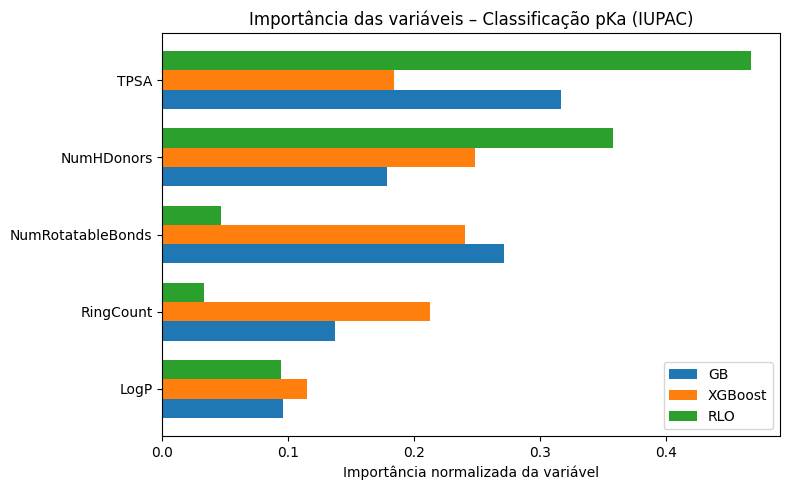

In [379]:
# Gerar as figuras para cada dataset

# IUPAC

plot_feature_importance_comparison(
    feature_importance_gb_class_iupac,
    feature_importance_xgb_class_iupac,
    feature_importance_ordinal_class_iupac,
    title="Importância das variáveis – Classificação pKa (IUPAC)",
    top_n=10
)

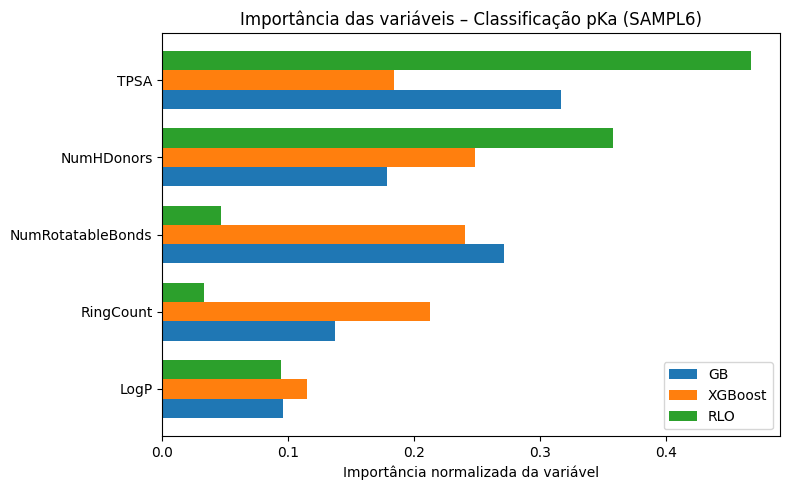

In [382]:
# SAMPL6

plot_feature_importance_comparison(
    feature_importance_gb_class_sampl6,
    feature_importance_xgb_class_sampl6,
    feature_importance_ordinal_class_sampl6,
    title="Importância das variáveis – Classificação pKa (SAMPL6)",
    top_n=10
)

#### Para o conjunto de dados IUPAC, ambos os modelos apresentaram valores de AUC semelhantes (0,674 para GB e 0,672 para XGBoost), indicando capacidade discriminativa comparável entre as classes de $\mathrm{p}K_a$. No entanto, o XGBoost obteve valores ligeiramente superiores de F1-score (0,623) e coeficiente de correlação de Matthews (MCC = 0,287), sugerindo melhor equilíbrio entre sensibilidade e especificidade, especialmente relevante em um cenário de classes desbalanceadas.

#### No conjunto SAMPL6, observou-se desempenho global superior em comparação ao IUPAC, com valores de AUC acima de 0,82 para ambos os modelos. O XGBoost novamente apresentou vantagem marginal, alcançando AUC de 0,826, F1-score de 0,684 e MCC de 0,427, enquanto o Gradient Boosting obteve AUC de 0,822, F1-score de 0,683 e MCC de 0,425. Esses resultados indicam maior separabilidade entre as faixas de $\mathrm{p}K_a$ no conjunto SAMPL6, possivelmente devido à maior homogeneidade estrutural e qualidade dos dados.

#### De forma geral, os resultados sugerem que a discriminação entre faixas de $\mathrm{p}K_a$ não é governada por descritores individuais, mas sim por relações multivariadas e não lineares entre descritores moleculares. Modelos baseados em árvores de decisão, especialmente o XGBoost, mostram-se mais eficazes para capturar essas interações complexas. Assim, o XGBoost foi adotado como modelo preferencial para análise de importância de descritores e classificação das faixas de $\mathrm{p}K_a$, enquanto o Gradient Boosting foi mantido como baseline robusto para comparação metodológica.

#### De forma geral, testes univariados (Kruskal–Wallis) falharam e modelos multivariados funcionaram bem. Esses resultados reforçam que o $\mathrm{p}K_a$ não é governado por um único descritor molecular, mas por interações não lineares entre propriedades topológicas, eletrônicas e estéricas.

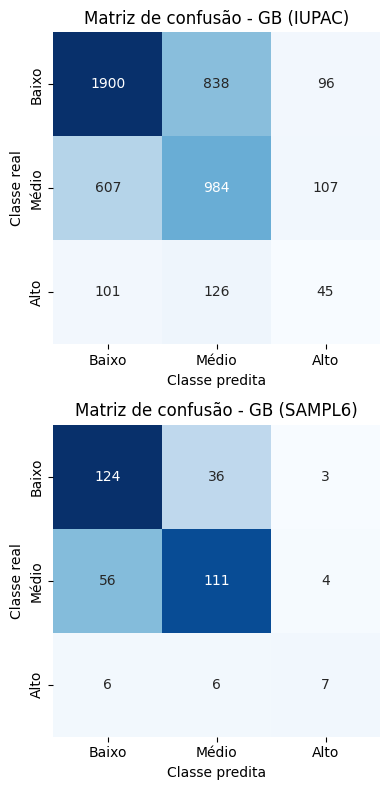

In [204]:
# Matrizes de confusão GB: IUPAC e SAMPL6

# Matrizes de confusão
cm_iupac_gb = confusion_matrix(y_test_iupac, y_pred_gb_iupac)
cm_sampl6_gb = confusion_matrix(y_test_sampl6, y_pred_gb_sampl6)

fig, axes = plt.subplots(2, 1, figsize=(4, 8))

titles = [
    "Matriz de confusão - GB (IUPAC)",
    "Matriz de confusão - GB (SAMPL6)",
]

cms = [
    cm_iupac_gb,
    cm_sampl6_gb,
]

for ax, cm, title in zip(axes.flatten(), cms, titles):
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        xticklabels=["Baixo", "Médio", "Alto"],
        yticklabels=["Baixo", "Médio", "Alto"],
        ax=ax
    )
    ax.set_title(title)
    ax.set_xlabel("Classe predita")
    ax.set_ylabel("Classe real")

plt.tight_layout()
plt.show()

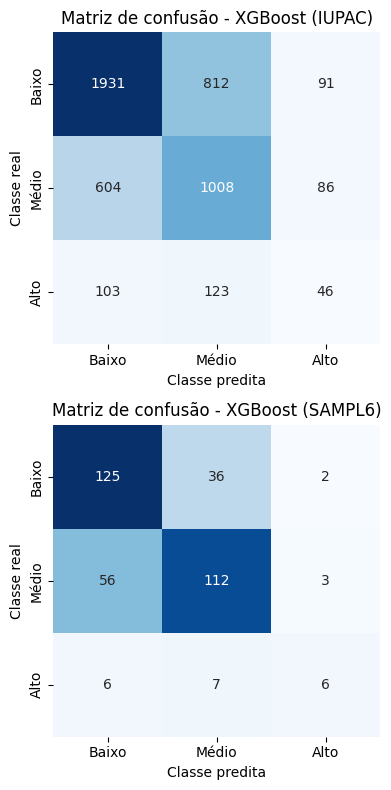

In [203]:
# Matrizes de confusão XGB: IUPAC e SAMPL6

# Matrizes de confusão
cm_iupac_xgb = confusion_matrix(y_test_iupac, y_pred_xgb_iupac)
cm_sampl6_xgb = confusion_matrix(y_test_sampl6, y_pred_xgb_sampl6)

fig, axes = plt.subplots(2, 1, figsize=(4, 8))

titles = [
    "Matriz de confusão - XGBoost (IUPAC)",
    "Matriz de confusão - XGBoost (SAMPL6)",
]

cms = [
    cm_iupac_xgb,
    cm_sampl6_xgb,
]

for ax, cm, title in zip(axes.flatten(), cms, titles):
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        xticklabels=["Baixo", "Médio", "Alto"],
        yticklabels=["Baixo", "Médio", "Alto"],
        ax=ax
    )
    ax.set_title(title)
    ax.set_xlabel("Classe predita")
    ax.set_ylabel("Classe real")

plt.tight_layout()
plt.show()

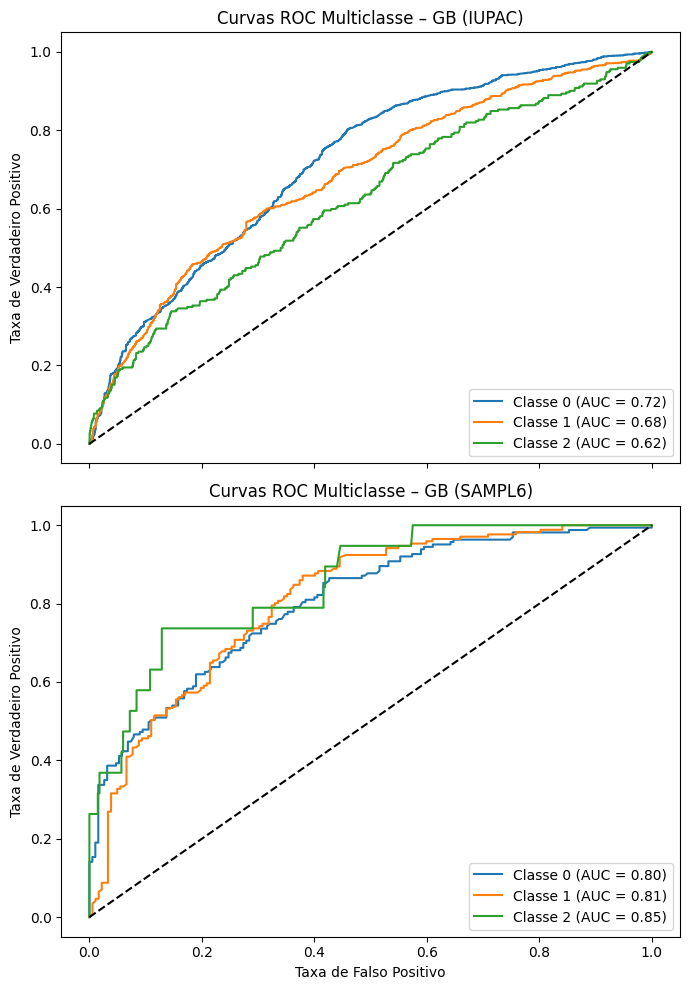

In [200]:
# Curvas ROC multiclasse GB: IUPAC e SAMPL6

fig, axes = plt.subplots(2, 1, figsize=(7, 10), sharex=True)

# ROC – IUPAC

classes_iupac = np.unique(y_test_iupac)
y_test_bin_iupac = label_binarize(y_test_iupac, classes=classes_iupac)
y_proba_iupac = clf_pipeline_iupac.predict_proba(X_test_iupac)

for i, cls in enumerate(classes_iupac):
    fpr, tpr, _ = roc_curve(y_test_bin_iupac[:, i], y_proba_iupac[:, i])
    roc_auc = auc(fpr, tpr)
    axes[0].plot(fpr, tpr, label=f"Classe {cls} (AUC = {roc_auc:.2f})")

axes[0].plot([0, 1], [0, 1], "k--")
axes[0].set_title("Curvas ROC Multiclasse – GB (IUPAC)")
axes[0].set_ylabel("Taxa de Verdadeiro Positivo")
axes[0].legend(loc="lower right")

# ROC – SAMPL6

classes_sampl6 = np.unique(y_test_sampl6)
y_test_bin_sampl6 = label_binarize(y_test_sampl6, classes=classes_sampl6)
y_proba_sampl6 = clf_pipeline_sampl6.predict_proba(X_test_sampl6)

for i, cls in enumerate(classes_sampl6):
    fpr, tpr, _ = roc_curve(y_test_bin_sampl6[:, i], y_proba_sampl6[:, i])
    roc_auc = auc(fpr, tpr)
    axes[1].plot(fpr, tpr, label=f"Classe {cls} (AUC = {roc_auc:.2f})")

axes[1].plot([0, 1], [0, 1], "k--")
axes[1].set_title("Curvas ROC Multiclasse – GB (SAMPL6)")
axes[1].set_xlabel("Taxa de Falso Positivo")
axes[1].set_ylabel("Taxa de Verdadeiro Positivo")
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

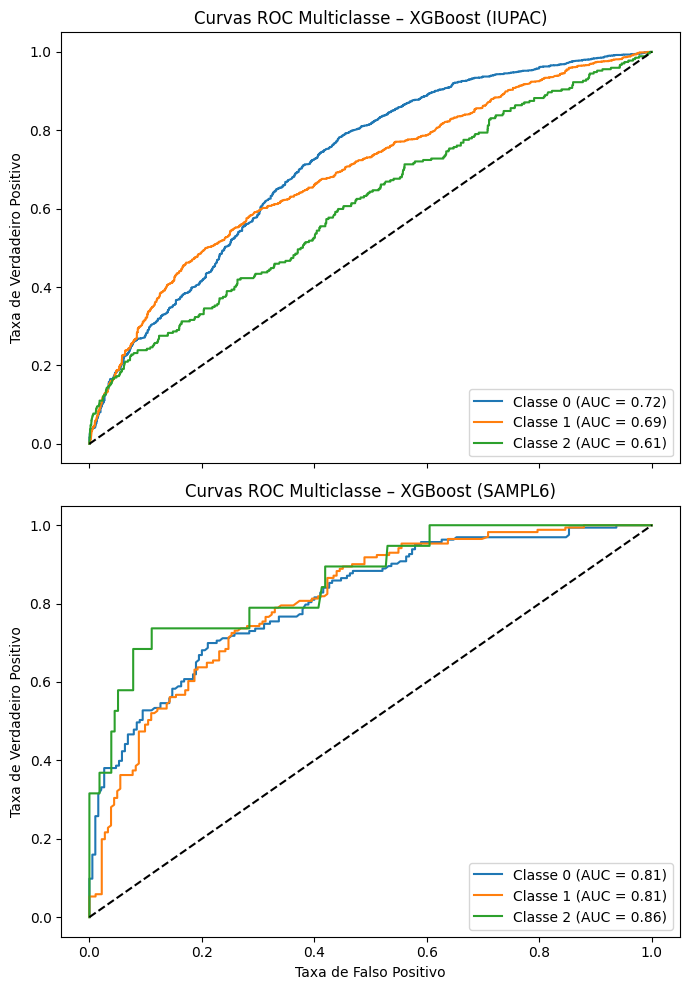

In [201]:
# Curvas ROC multiclasse XGB: IUPAC e SAMPL6

fig, axes = plt.subplots(2, 1, figsize=(7, 10), sharex=True)

# ROC – IUPAC (XGBoost)

classes_iupac = np.unique(y_test_iupac)
y_test_bin_iupac = label_binarize(y_test_iupac, classes=classes_iupac)
y_proba_iupac = xgb_pipeline_iupac.predict_proba(X_test_iupac)

for i, cls in enumerate(classes_iupac):
    fpr, tpr, _ = roc_curve(y_test_bin_iupac[:, i], y_proba_iupac[:, i])
    roc_auc = auc(fpr, tpr)
    axes[0].plot(fpr, tpr, label=f"Classe {cls} (AUC = {roc_auc:.2f})")

axes[0].plot([0, 1], [0, 1], "k--")
axes[0].set_title("Curvas ROC Multiclasse – XGBoost (IUPAC)")
axes[0].set_ylabel("Taxa de Verdadeiro Positivo")
axes[0].legend(loc="lower right")

# ROC – SAMPL6 (XGBoost)

classes_sampl6 = np.unique(y_test_sampl6)
y_test_bin_sampl6 = label_binarize(y_test_sampl6, classes=classes_sampl6)
y_proba_sampl6 = xgb_pipeline_sampl6.predict_proba(X_test_sampl6)

for i, cls in enumerate(classes_sampl6):
    fpr, tpr, _ = roc_curve(y_test_bin_sampl6[:, i], y_proba_sampl6[:, i])
    roc_auc = auc(fpr, tpr)
    axes[1].plot(fpr, tpr, label=f"Classe {cls} (AUC = {roc_auc:.2f})")

axes[1].plot([0, 1], [0, 1], "k--")
axes[1].set_title("Curvas ROC Multiclasse – XGBoost (SAMPL6)")
axes[1].set_xlabel("Taxa de Falso Positivo")
axes[1].set_ylabel("Taxa de Verdadeiro Positivo")
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

In [388]:
# Função para projeção PCA por classe predita com padronização

def plot_pca_projection(X, y_pred, title):

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA(n_components=2, random_state=42)
    X_proj = pca.fit_transform(X)

    plt.figure(figsize=(7, 6))
    sns.scatterplot(
        x=X_proj[:, 0],
        y=X_proj[:, 1],
        hue=y_pred,
        palette="Set2",
        alpha=0.7,
        edgecolor=None
    )

    plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
    plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
    plt.title(title)
    plt.legend(title="Classe predita")
    plt.tight_layout()
    plt.show()

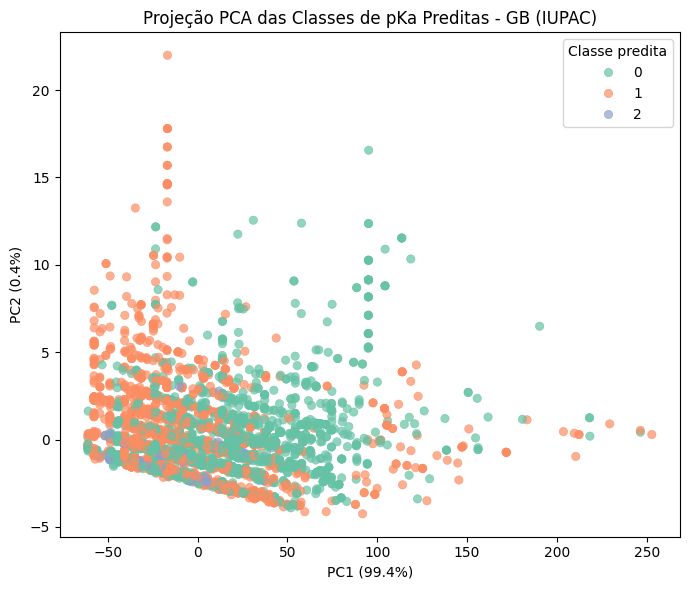

In [389]:
# PCA Gradient Boosting (GB)

# PCA para IUPAC

plot_pca_projection(X_test_iupac, y_pred_gb_iupac, "Projeção PCA das Classes de pKa Preditas - GB (IUPAC)")

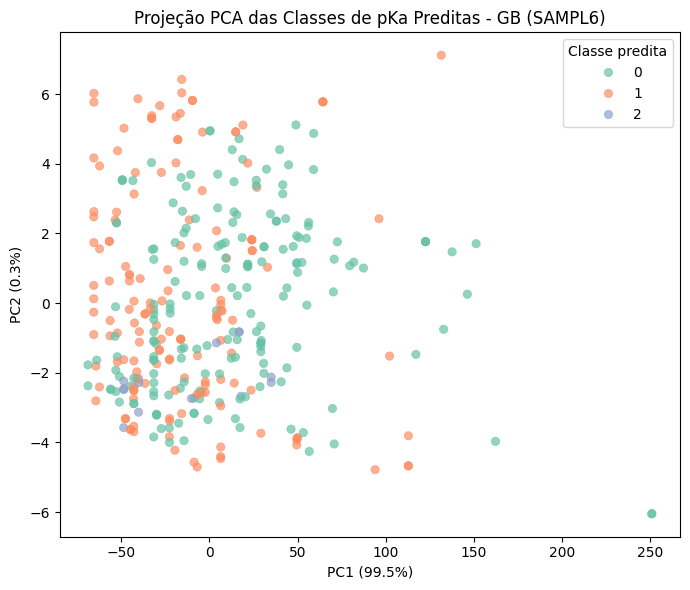

In [390]:
# PCA para SAMPL6

plot_pca_projection(X_test_sampl6, y_pred_gb_sampl6, "Projeção PCA das Classes de pKa Preditas - GB (SAMPL6)")

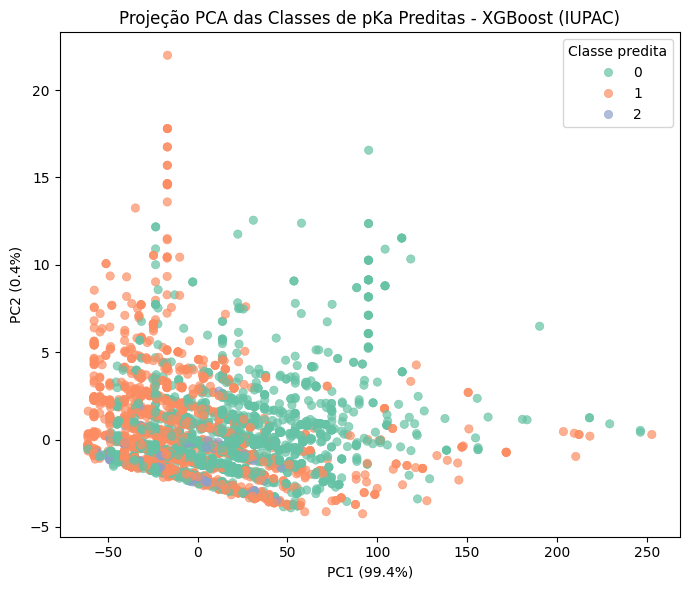

In [391]:
# PCA XGBoost (GB)

# PCA para IUPAC

plot_pca_projection(X_test_iupac, y_pred_xgb_iupac, "Projeção PCA das Classes de pKa Preditas - XGBoost (IUPAC)")

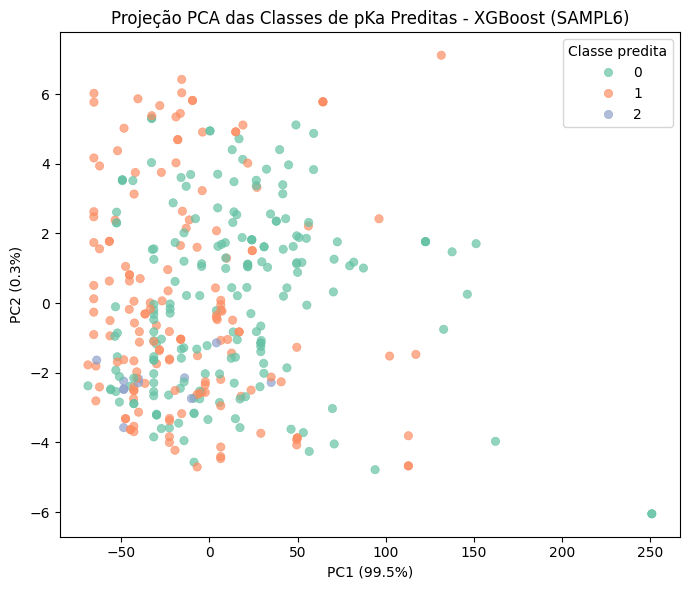

In [392]:
# PCA XGBoost (GB)

# PCA para SAMPL6

plot_pca_projection(X_test_sampl6, y_pred_xgb_sampl6, "Projeção PCA das Classes de pKa Preditas - XGBoost (SAMPL6)")

#### A PCA foi empregada exclusivamente para fins exploratórios e de visualização, não sendo utilizada como etapa de pré-processamento para os modelos preditivos.

In [400]:
# Função para projeção Kernel PCA por classe predita com padronização

def plot_kernel_pca_projection(X, y_pred, title):

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    kpca = KernelPCA(
        n_components=2,
        kernel="rbf",
        gamma=0.5,
        random_state=42
    )
    X_proj = kpca.fit_transform(X_scaled)

    plt.figure(figsize=(7, 6))
    sns.scatterplot(
        x=X_proj[:, 0],
        y=X_proj[:, 1],
        hue=y_pred,
        palette="Set2",
        alpha=0.7
    )

    plt.xlabel("kPC1")
    plt.ylabel("kPC2")
    plt.legend(title="Classe predita")
    plt.tight_layout()
    plt.show()

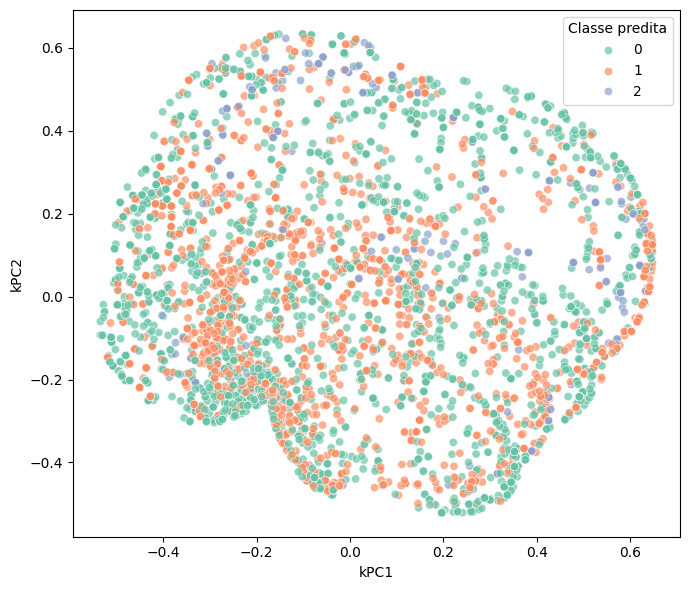

In [401]:
# KernelPCA Gradient Boosting (GB)

# KernelPCA para IUPAC

plot_kernel_pca_projection(X_test_iupac, y_pred_gb_iupac, "Projeção Kernel-PCA das Classes de pKa Preditas - GB (IUPAC)")

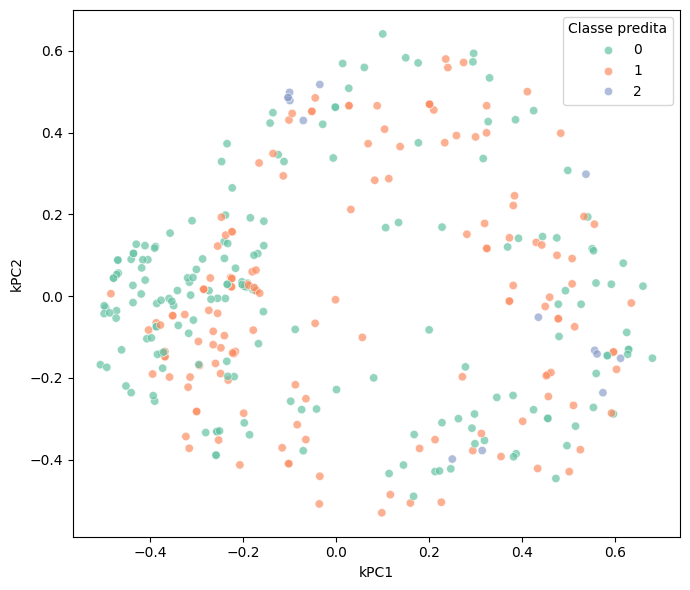

In [402]:
# KernelPCA para SAMPL6

plot_kernel_pca_projection(X_test_sampl6, y_pred_gb_sampl6, "Projeção Kernel-PCA das Classes de pKa Preditas - GB (SAMPL6)")

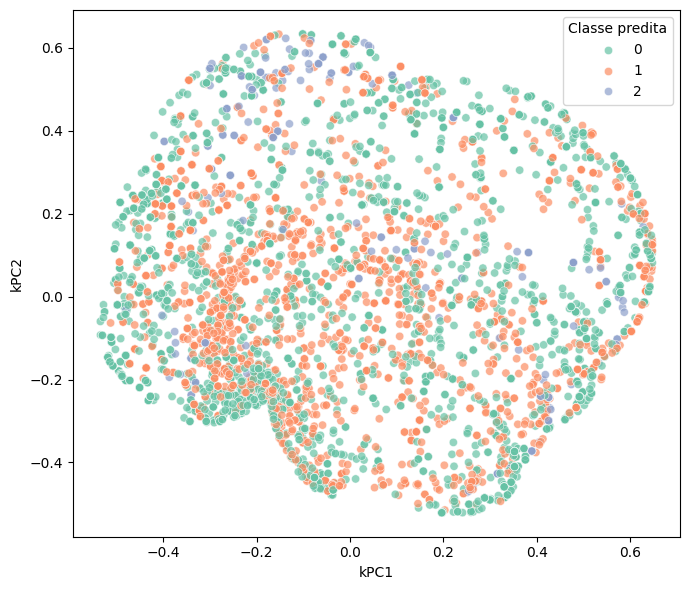

In [403]:
# KernelPCA XGBoost 

# KernelPCA para IUPAC

plot_kernel_pca_projection(X_test_iupac, y_pred_xgb_iupac, "Projeção Kernel-PCA das Classes de pKa Preditas - XGBoost (IUPAC)")

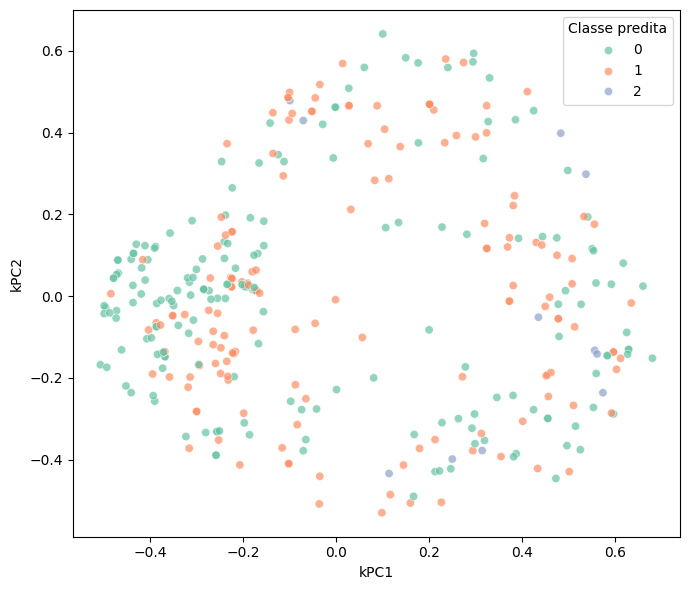

In [404]:
# KernelPCA para SAMPL6

plot_kernel_pca_projection(X_test_sampl6, y_pred_xgb_sampl6, "Projeção Kernel-PCA das Classes de pKa Preditas - XGBoost (SAMPL6)")

In [364]:
# Regressão Logística Ordinal como benchmarking (classificação)

ordinal_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("clf", LogisticAT(alpha=1.0))  # alpha = regularização L2
])

In [365]:
# Treino Ordinal IUPAC

ordinal_pipeline_iupac = ordinal_pipeline.fit(X_train_iupac, y_train_iupac)

In [366]:
# Treino Ordinal SAMPL6

ordinal_pipeline_sampl6 = ordinal_pipeline.fit(X_train_sampl6, y_train_sampl6)

In [367]:
# Avaliação Ordinal IUPAC

y_pred_ord_iupac = ordinal_pipeline_iupac.predict(X_test_iupac)
y_prob_ord_iupac = ordinal_pipeline_iupac.predict_proba(X_test_iupac)

auc_ord_iupac = roc_auc_score(y_test_iupac, y_prob_ord_iupac, multi_class="ovr")
f1_ord_iupac = f1_score(y_test_iupac, y_pred_ord_iupac, average="weighted")
mcc_ord_iupac = matthews_corrcoef(y_test_iupac, y_pred_ord_iupac)

print(f"AUC Ordinal IUPAC: {auc_ord_iupac:.3f}")
print(f"F1 Ordinal IUPAC: {f1_ord_iupac:.3f}")
print(f"MCC Ordinal IUPAC: {mcc_ord_iupac:.3f}")

AUC Ordinal IUPAC: 0.633
F1 Ordinal IUPAC: 0.488
MCC Ordinal IUPAC: 0.171


In [368]:
# Avaliação Ordinal SAMPL6

y_pred_ord_sampl6 = ordinal_pipeline_sampl6.predict(X_test_sampl6)
y_prob_ord_sampl6 = ordinal_pipeline_sampl6.predict_proba(X_test_sampl6)

auc_ord_sampl6 = roc_auc_score(y_test_sampl6, y_prob_ord_sampl6, multi_class="ovr")
f1_ord_sampl6 = f1_score(y_test_sampl6, y_pred_ord_sampl6, average="weighted")
mcc_ord_sampl6 = matthews_corrcoef(y_test_sampl6, y_pred_ord_sampl6)

print(f"AUC Ordinal SAMPL6: {auc_ord_sampl6:.3f}")
print(f"F1 Ordinal SAMPL6: {f1_ord_sampl6:.3f}")
print(f"MCC Ordinal SAMPL6: {mcc_ord_sampl6:.3f}")

AUC Ordinal SAMPL6: 0.691
F1 Ordinal SAMPL6: 0.544
MCC Ordinal SAMPL6: 0.166


In [370]:
# Importância das variáveis IUPAC

# Extrair os coeficientes

coef_ordinal_iupac = ordinal_pipeline_iupac.named_steps["clf"].coef_
coef_ordinal_iupac

array([-0.28568707, -1.41710131,  1.08594977,  0.14248052,  0.09967584])

In [372]:
# Usar o valor absoluto como medida de importância

importances_ordinal_class_iupac = np.abs(coef_ordinal_iupac)

feature_importance_ordinal_class_iupac = (pd.Series(importances_ordinal_class_iupac, index=X_train_iupac.columns).sort_values(ascending=False))

In [380]:
# Importância das variáveis SAMPL6

# Extrair os coeficientes

coef_ordinal_sampl6 = ordinal_pipeline_sampl6.named_steps["clf"].coef_
coef_ordinal_sampl6

array([-0.28568707, -1.41710131,  1.08594977,  0.14248052,  0.09967584])

In [381]:
# Usar o valor absoluto como medida de importância

importances_ordinal_class_sampl6 = np.abs(coef_ordinal_sampl6)

feature_importance_ordinal_class_sampl6 = (pd.Series(importances_ordinal_class_sampl6, index=X_train_sampl6.columns).sort_values(ascending=False))

#### A Regressão Logística Ordinal (RLO) é um modelo linear, portanto a “importância” das variáveis deve ser extraída a partir dos coeficientes do modelo.

## Pipeline 2 (Regressão para validar capacidade preditiva): Padronizar (StandardScaler) -> Regressão (Gradient Boosting Regressor / XGBRegressor) -> Avaliação (RMSE, MAE, R2)

#### Em seguida, a predição de valores contínuos de pKa foi abordada como um problema de regressão supervisionada, para o qual não se aplicam técnicas de balanceamento de classes, sendo empregada apenas a padronização dos descritores e o ajuste dos modelos regressivos.

#### A predição precisa de $\mathrm{p}K_a$ não depende de um único descritor, mas emerge da combinação multivariada e não linear de propriedades químicas, capturada de forma eficaz por métodos de ensemble baseados em árvores.

#### A padronização é aplicada antes do treinamento para garantir estabilidade numérica e comparabilidade entre descritores físico-químicos de diferentes escalas, enquanto o Gradient Boosting Regressor é empregado para capturar relações não lineares entre os descritores moleculares e o $\mathrm{p}K_a$ contínuo.

In [228]:
# Pipeline com Gradient Boosting (GB) Regressor

gb_reg_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("reg", GradientBoostingRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    ))
])

In [229]:
# Treino Gradient Boosting Regressor: IUPAC e SAMPL6

gb_reg_pipeline_iupac = gb_reg_pipeline.fit(X_train_iupac, y_train_iupac_cont)

gb_reg_pipeline_sampl6 = gb_reg_pipeline.fit(X_train_sampl6, y_train_sampl6_cont)

In [236]:
# Avaliação GB Regressor: IUPAC

y_pred_gb_reg_iupac = gb_reg_pipeline_iupac.predict(X_test_iupac)

rmse_gb_iupac = np.sqrt(mean_squared_error(y_test_iupac_cont, y_pred_gb_reg_iupac))
mae_gb_iupac = mean_absolute_error(y_test_iupac_cont, y_pred_gb_reg_iupac)
r2_gb_iupac = r2_score(y_test_iupac_cont, y_pred_gb_reg_iupac)

print(f"RMSE GB IUPAC: {rmse_gb_iupac:.3f}")
print(f"MAE GB IUPAC: {mae_gb_iupac:.3f}")
print(f"R2 GB IUPAC: {r2_gb_iupac:.3f}")

RMSE GB IUPAC: 321.832
MAE GB IUPAC: 37.075
R2 GB IUPAC: -6270.021


In [242]:
# Baseline ingênuo: IUPAC

y_mean = np.mean(y_train_iupac_cont)
y_pred_baseline = np.full_like(y_test_iupac_cont, y_mean)

mae_baseline = mean_absolute_error(y_test_iupac_cont, y_pred_baseline)

In [243]:
print(y_mean)

5.607111565086139


In [244]:
print(y_pred_baseline)

[5.60711157 5.60711157 5.60711157 ... 5.60711157 5.60711157 5.60711157]


In [245]:
print(mae_baseline)

3.2976686900745413


In [237]:
# Avaliação GB Regressor: SAMPL6

y_pred_gb_reg_sampl6 = gb_reg_pipeline_sampl6.predict(X_test_sampl6)

rmse_gb_sampl6 = np.sqrt(mean_squared_error(y_test_sampl6_cont, y_pred_gb_reg_sampl6))
mae_gb_sampl6 = mean_absolute_error(y_test_sampl6_cont, y_pred_gb_reg_sampl6)
r2_gb_sampl6 = r2_score(y_test_sampl6_cont, y_pred_gb_reg_sampl6)

print(f"RMSE GB SAMPL6: {rmse_gb_sampl6:.3f}")
print(f"MAE GB SAMPL6: {mae_gb_sampl6:.3f}")
print(f"R2 GB SAMPL6: {r2_gb_sampl6:.3f}")

RMSE GB SAMPL6: 760.286
MAE GB SAMPL6: 102.752
R2 GB SAMPL6: -0.785


In [246]:
# Baseline ingênuo: SAMPL6

y_mean = np.mean(y_train_sampl6_cont)
y_pred_baseline = np.full_like(y_test_sampl6_cont, y_mean)

mae_baseline = mean_absolute_error(y_test_sampl6_cont, y_pred_baseline)

In [248]:
print(y_mean)

39.21304235127479


In [249]:
print(y_pred_baseline)

[39.21304235 39.21304235 39.21304235 39.21304235 39.21304235 39.21304235
 39.21304235 39.21304235 39.21304235 39.21304235 39.21304235 39.21304235
 39.21304235 39.21304235 39.21304235 39.21304235 39.21304235 39.21304235
 39.21304235 39.21304235 39.21304235 39.21304235 39.21304235 39.21304235
 39.21304235 39.21304235 39.21304235 39.21304235 39.21304235 39.21304235
 39.21304235 39.21304235 39.21304235 39.21304235 39.21304235 39.21304235
 39.21304235 39.21304235 39.21304235 39.21304235 39.21304235 39.21304235
 39.21304235 39.21304235 39.21304235 39.21304235 39.21304235 39.21304235
 39.21304235 39.21304235 39.21304235 39.21304235 39.21304235 39.21304235
 39.21304235 39.21304235 39.21304235 39.21304235 39.21304235 39.21304235
 39.21304235 39.21304235 39.21304235 39.21304235 39.21304235 39.21304235
 39.21304235 39.21304235 39.21304235 39.21304235 39.21304235 39.21304235
 39.21304235 39.21304235 39.21304235 39.21304235 39.21304235 39.21304235
 39.21304235 39.21304235 39.21304235 39.21304235 39

In [250]:
print(mae_baseline)

77.83800197136642


#### A avaliação de modelos de regressão foi contextualizada por meio de um baseline ingênuo baseado na média do $\mathrm{p}K_a$ do conjunto de treinamento. Para o dataset IUPAC, esse baseline apresentou MAE de aproximadamente 3,3 unidades de $\mathrm{p}K_a$, refletindo uma distribuição mais concentrada e homogênea dos valores experimentais. Em contraste, o dataset SAMPL6 exibiu um $\mathrm{p}K_a$ médio elevado e um MAE baseline significativamente maior (≈ 77,8), evidenciando elevada dispersão e heterogeneidade dos dados. Em ambos os casos, os modelos de regressão não superaram o desempenho do baseline, indicando limitações na capacidade dos descritores utilizados em capturar a complexidade necessária para a predição contínua do $\mathrm{p}K_a$. Esses resultados reforçam a adequação da formulação do problema como classificação ordinal, especialmente para conjuntos de dados com alta variabilidade estrutural e físico-química.

In [251]:
# Pipeline com XGBoostRegressor

xgb_reg_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("reg", XGBRegressor(
        objective="reg:squarederror",
        n_estimators=500,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        tree_method="hist",
        random_state=42
    ))
])

In [252]:
# Treino XGBoost Regressor: IUPAC e SAMPL6

xgb_reg_pipeline_iupac = xgb_reg_pipeline.fit(X_train_iupac, y_train_iupac_cont)

xgb_reg_pipeline_sampl6 = xgb_reg_pipeline.fit(X_train_sampl6, y_train_sampl6_cont)

In [255]:
# Avaliação XGBoost Regressor: IUPAC

y_pred_xgb_reg_iupac = xgb_reg_pipeline_iupac.predict(X_test_iupac)

rmse_xgb_iupac = np.sqrt(mean_squared_error(y_test_iupac_cont, y_pred_xgb_reg_iupac))
mae_xgb_iupac = mean_absolute_error(y_test_iupac_cont, y_pred_xgb_reg_iupac)
r2_xgb_iupac = r2_score(y_test_iupac_cont, y_pred_xgb_reg_iupac)

print(f"RMSE XGB IUPAC: {rmse_xgb_iupac:.3f}")
print(f"MAE XGB IUPAC: {mae_xgb_iupac:.3f}")
print(f"R2 XGB IUPAC: {r2_xgb_iupac:.3f}")

RMSE XGB IUPAC: 379.999
MAE XGB IUPAC: 89.240
R2 XGB IUPAC: -8741.718


In [405]:
# Avaliação XGBoost Regressor: SAMPL6

y_pred_xgb_reg_sampl6 = xgb_reg_pipeline_sampl6.predict(X_test_sampl6)

rmse_xgb_sampl6 = np.sqrt(mean_squared_error(y_test_sampl6_cont, y_pred_xgb_reg_sampl6))
mae_xgb_sampl6 = mean_absolute_error(y_test_sampl6_cont, y_pred_xgb_reg_sampl6)
r2_xgb_sampl6 = r2_score(y_test_sampl6_cont, y_pred_xgb_reg_sampl6)

print(f"RMSE XGB SAMPL6: {rmse_xgb_sampl6:.3f}")
print(f"MAE XGB SAMPL6: {mae_xgb_sampl6:.3f}")
print(f"R2 XGB SAMPL6: {r2_xgb_sampl6:.3f}")

RMSE XGB SAMPL6: 721.551
MAE XGB SAMPL6: 118.713
R2 XGB SAMPL6: -0.608


In [407]:
# Pipeline com DTRegressor

dt_reg_pipeline = Pipeline(steps=[
    ("reg", DecisionTreeRegressor(
        criterion="squared_error",
        max_depth=5,        # controla overfitting
        min_samples_leaf=5, # suaviza previsões
        random_state=42
    ))
])

In [408]:
# Treino DTRegressor: IUPAC e SAMPL6

dt_reg_pipeline_iupac = dt_reg_pipeline.fit(X_train_iupac, y_train_iupac_cont)

dt_reg_pipeline_sampl6 = dt_reg_pipeline.fit(X_train_sampl6, y_train_sampl6_cont)

In [409]:
# Avaliação DTRegressor: IUPAC

y_pred_dt_iupac = dt_reg_pipeline_iupac.predict(X_test_iupac)

rmse_dt_iupac = np.sqrt(mean_squared_error(y_test_iupac_cont, y_pred_dt_iupac))
mae_dt_iupac  = mean_absolute_error(y_test_iupac_cont, y_pred_dt_iupac)
r2_dt_iupac   = r2_score(y_test_iupac_cont, y_pred_dt_iupac)

print(f"RMSE DT IUPAC: {rmse_dt_iupac:.3f}")
print(f"MAE  DT IUPAC: {mae_dt_iupac:.3f}")
print(f"R2   DT IUPAC: {r2_dt_iupac:.3f}")

RMSE DT IUPAC: 187.025
MAE  DT IUPAC: 30.732
R2   DT IUPAC: -2116.781


In [410]:
# Avaliação DTRegressor: SAMPL6

y_pred_dt_sampl6 = dt_reg_pipeline_sampl6.predict(X_test_sampl6)

rmse_dt_sampl6 = np.sqrt(mean_squared_error(y_test_sampl6_cont, y_pred_dt_sampl6))
mae_dt_sampl6  = mean_absolute_error(y_test_sampl6_cont, y_pred_dt_sampl6)
r2_dt_sampl6   = r2_score(y_test_sampl6_cont, y_pred_dt_sampl6)

print(f"RMSE DT SAMPL6: {rmse_dt_sampl6:.3f}")
print(f"MAE  DT SAMPL6: {mae_dt_sampl6:.3f}")
print(f"R2   DT SAMPL6: {r2_dt_sampl6:.3f}")

RMSE DT SAMPL6: 605.209
MAE  DT SAMPL6: 83.487
R2   DT SAMPL6: -0.131


In [416]:
# Gráfico Real vs. Predito: painel 3 × 2 (única figura)

import matplotlib.pyplot as plt
import numpy as np

def plot_real_vs_pred_grid(
    y_true_iupac, preds_iupac,
    y_true_sampl6, preds_sampl6,
    model_names
):
    fig, axes = plt.subplots(
        nrows=3,
        ncols=2,
        figsize=(10, 14),
        sharex='col',
        sharey='row'
    )

    datasets = [
        ("IUPAC", y_true_iupac, preds_iupac),
        ("SAMPL6", y_true_sampl6, preds_sampl6)
    ]

    for col, (ds_name, y_true, preds) in enumerate(datasets):
        for row, (model_name, y_pred) in enumerate(zip(model_names, preds)):
            ax = axes[row, col]

            ax.scatter(
                y_true,
                y_pred,
                alpha=0.5
            )

            # Linha identidade
            min_val = min(y_true.min(), y_pred.min())
            max_val = max(y_true.max(), y_pred.max())
            ax.plot(
                [min_val, max_val],
                [min_val, max_val],
                linestyle="--"
            )

            ax.set_title(f"{model_name} ({ds_name})")

            if col == 0:
                ax.set_ylabel("pKa predito")
            if row == 2:
                ax.set_xlabel("pKa real")

    plt.tight_layout()
    plt.show()

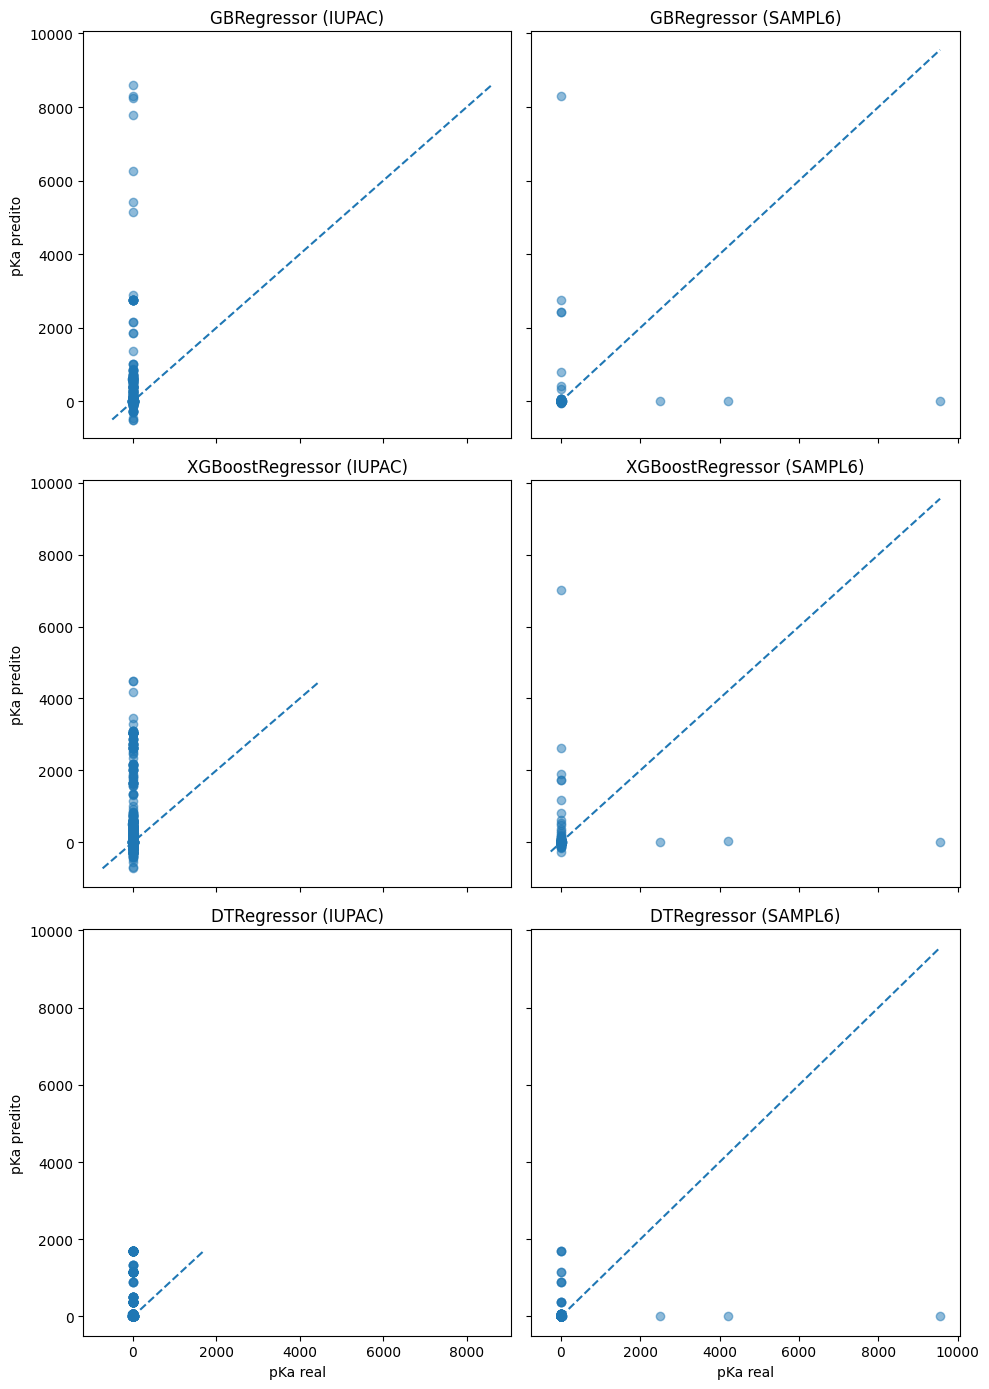

In [417]:
model_names = [
    "GBRegressor",
    "XGBoostRegressor",
    "DTRegressor"
]

preds_iupac = [
    y_pred_gb_reg_iupac,
    y_pred_xgb_reg_iupac,
    y_pred_dt_iupac
]

preds_sampl6 = [
    y_pred_gb_reg_sampl6,
    y_pred_xgb_reg_sampl6,
    y_pred_dt_sampl6
]

plot_real_vs_pred_grid(
    y_test_iupac_cont,
    preds_iupac,
    y_test_sampl6_cont,
    preds_sampl6,
    model_names
)